In [137]:
!pip install tensorflow==2.0.0rc0 &> log

import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
import cv2 as cv
%matplotlib inline
from sklearn.model_selection import train_test_split

ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


In [133]:
data = pd.read_csv("dataset/map.tsv", sep="\t",header=None)
columns = ["FileName", "Value"]
data.columns = columns
n = data.shape[0]

In [134]:
def cut_into_six(image):
    X = np.zeros(shape=(6, 64, 25, 1))
    #y = np.array(6, )
    X[0] = image[:,:25]
    X[1] = image[:,25:50]
    X[2] = image[:,50:75]
    X[3] = image[:,75:100]
    X[4] = image[:,100:125]
    X[5] = image[:,125:150]
    return X

In [138]:
data_train, data_test = train_test_split(data, test_size = 0.2)

In [149]:
char for char in word

['hui']

In [207]:
#with color
def make_dataset_color(data):
    X = np.zeros((n, 64, 150, 3), dtype=np.uint8)
    y = []
    for i in tqdm(range(n)):
        file_name = data.loc[i]["FileName"]
        answer = data.loc[i]["Value"]
        X[i] = plt.imread(os.path.join(f"dataset/img", file_name))[:, 125:275]
        y.append(answer.upper())
    y = np.array(y).reshape(n,)
    X = X.astype(float) / 255.
    return X, y    
#gray
def make_dataset_gray_cut(data):
    X = np.zeros((len(data)*6, 64, 25, 1), dtype=np.uint8)
    y = np.zeros((len(data)*6), dtype=str)
    j = 0
    for row in tqdm(data.iterrows()):
        row = row[1]
        file_name = row["FileName"]
        label = row["Value"]
        image = cv.imread(os.path.join(f"dataset/img", file_name))[:, 125:275]
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY).reshape(64, 150, 1) #make it gray!
        X[j:j+6] = cut_into_six(image)
        y[j:j+6] = [char for char in label.upper()]
        j += 6
    X = X.astype(float) / 255.
    return X, y

def make_dataset_gray(data):
    X = np.zeros((len(data), 64, 150, 1), dtype=np.uint8)
    y = []
    j = 0
    for row in tqdm(data.iterrows()):
        row = row[1]
        file_name = row["FileName"]
        label = row["Value"]
        image = cv.imread(os.path.join(f"dataset/img", file_name))[:, 125:275]
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY).reshape(64, 150, 1)
        X[j] = image.reshape(64, 150, 1) #make it gray!
        y.append(label.upper())
        j += 1
    y = np.array(y).reshape(-1,)
    X = X.astype(float) / 255.    
    return X, y


In [208]:
X_r_test, y_r_test = make_dataset_gray(data_test)

In [211]:
#X, y = make_dataset_gray(data)
X, y = make_dataset_gray_cut(data_train)
#X, y = make_dataset_color(data)

In [159]:
#reshape y
classes_names = np.array(['А', 'Б', 'В', 'Г', 'Д', 
                              'Е', 'Ж', 'З', 'И', 'К', 
                              'Л', 'М', 'Н', 'О', 'П',
                              'Р', 'С', 'Т', 'У', 'Ф',
                              'Х', 'Ц', 'Ч', 'Э', 'Ю',
                              'Я', '1', '2', '3', '4',
                              '5', '6', '7', '8', '9'])
def prepare_y(y):
    Y = np.zeros((y.shape[0], 35), dtype=np.uint8)
    classes_names = np.array(['А', 'Б', 'В', 'Г', 'Д', 
                              'Е', 'Ж', 'З', 'И', 'К', 
                              'Л', 'М', 'Н', 'О', 'П',
                              'Р', 'С', 'Т', 'У', 'Ф',
                              'Х', 'Ц', 'Ч', 'Э', 'Ю',
                              'Я', '1', '2', '3', '4',
                              '5', '6', '7', '8', '9'])
    classes_names_dict = {}
    for i in range(classes_names.shape[0]):
        classes_names_dict[classes_names[i]] = i
    for i in range(y.shape[0]):
        current_vector = np.array([])
        for symbol in y[i]:
            current_s = np.zeros(35)
            current_s[classes_names_dict[symbol]] = 1
            current_vector = np.append(current_vector, current_s)
        Y[i] = current_vector
    return Y

In [212]:
y = prepare_y(y)

In [161]:
#Train/Val/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [162]:
X_train[0].shape, X_train.shape, X.shape

((64, 25, 1), (66915, 64, 25, 1), (104556, 64, 25, 1))

In [10]:
def captcha_metric(y_true, y_pred):
    y_pred = keras.backend.reshape(y_pred, (-1,35))
    y_true = keras.backend.reshape(y_true, (-1,35))
    y_p = keras.backend.argmax(y_pred,axis=1)
    y_t = keras.backend.argmax(y_true,axis=1)
    ground_truth = keras.backend.reshape(keras.backend.equal(y_p, y_t), (-1, 6))
    ground_truth = keras.backend.all(ground_truth, axis = 1)
    r = keras.backend.mean(ground_truth)
    return r
def symbols_metric(y_true, y_pred):
    y_pred = keras.backend.reshape(y_pred, (-1,35))
    y_true = keras.backend.reshape(y_true, (-1,35))
    y_p = keras.backend.argmax(y_pred,axis=1)
    y_t = keras.backend.argmax(y_true,axis=1)
    r = keras.backend.mean(keras.backend.cast(keras.backend.equal(y_p, y_t), 'float32'))
    return r


In [213]:
#CUT CUT CUT
my_model = keras.models.Sequential()
my_model.add(L.InputLayer(X_train[0].shape))
my_model.add(L.Conv2D(filters=32, kernel_size = [3, 3], activation = 'relu'))
#my_model.add(L.Dropout(0.2))
my_model.add(L.MaxPooling2D(pool_size=(2,2)))
my_model.add(L.Conv2D(filters=64, kernel_size = [3, 3], activation = 'relu'))
my_model.add(L.Dropout(0.2))
my_model.add(L.MaxPooling2D(pool_size=(2,2)))
my_model.add(L.Conv2D(filters=128, kernel_size = [4, 4], activation = 'relu'))
my_model.add(L.Dropout(0.25))
my_model.add(L.Flatten())
my_model.add(L.Dropout(0.2))
my_model.add(L.Dense(70, activation='relu'))
my_model.add(L.Dense(35, activation='softmax'))
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer_snatch=keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #change to captcha_metric
my_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 23, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 11, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 9, 64)         18496     
_________________________________________________________________
dropout_19 (Dropout)         (None, 29, 9, 64)         0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 4, 64)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 1, 128)        131200    
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 1, 128)       

In [166]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()
my_model.fit(X_train, Y_train, batch_size=64, epochs=20,
             verbose=1,
             callbacks=[history], validation_data=[X_val, Y_val])

Train on 66915 samples, validate on 16729 samples
Epoch 1/20


11776/66915 [====>.........................] - ETA: 10:19 - loss: 3.5651 - accuracy: 0.015 - ETA: 6:41 - loss: 3.6289 - accuracy: 0.023 - ETA: 5:28 - loss: 3.5989 - accuracy: 0.02 - ETA: 4:51 - loss: 3.6015 - accuracy: 0.01 - ETA: 4:29 - loss: 3.5900 - accuracy: 0.03 - ETA: 4:14 - loss: 3.5869 - accuracy: 0.02 - ETA: 4:05 - loss: 3.5824 - accuracy: 0.02 - ETA: 3:57 - loss: 3.5774 - accuracy: 0.03 - ETA: 3:51 - loss: 3.5739 - accuracy: 0.02 - ETA: 3:46 - loss: 3.5684 - accuracy: 0.02 - ETA: 3:41 - loss: 3.5590 - accuracy: 0.02 - ETA: 3:38 - loss: 3.5570 - accuracy: 0.03 - ETA: 3:35 - loss: 3.5509 - accuracy: 0.03 - ETA: 3:33 - loss: 3.5469 - accuracy: 0.03 - ETA: 3:30 - loss: 3.5452 - accuracy: 0.03 - ETA: 3:28 - loss: 3.5418 - accuracy: 0.03 - ETA: 3:27 - loss: 3.5397 - accuracy: 0.03 - ETA: 3:25 - loss: 3.5389 - accuracy: 0.03 - ETA: 3:24 - loss: 3.5361 - accuracy: 0.03 - ETA: 3:22 - loss: 3.5338 - accuracy: 0.03 - ETA: 3:21 - loss: 3.5292 - accuracy: 0.03 - ETA: 3:20 - loss: 3.5305 -

23680/66915 [=========>....................] - ETA: 2:33 - loss: 3.4454 - accuracy: 0.03 - ETA: 2:33 - loss: 3.4451 - accuracy: 0.03 - ETA: 2:33 - loss: 3.4448 - accuracy: 0.03 - ETA: 2:33 - loss: 3.4446 - accuracy: 0.03 - ETA: 2:33 - loss: 3.4445 - accuracy: 0.03 - ETA: 2:32 - loss: 3.4444 - accuracy: 0.03 - ETA: 2:32 - loss: 3.4441 - accuracy: 0.03 - ETA: 2:32 - loss: 3.4441 - accuracy: 0.03 - ETA: 2:32 - loss: 3.4439 - accuracy: 0.03 - ETA: 2:32 - loss: 3.4438 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4435 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4433 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4429 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4426 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4422 - accuracy: 0.03 - ETA: 2:31 - loss: 3.4424 - accuracy: 0.03 - ETA: 2:30 - loss: 3.4421 - accuracy: 0.03 - ETA: 2:30 - loss: 3.4419 - accuracy: 0.03 - ETA: 2:30 - loss: 3.4417 - accuracy: 0.03 - ETA: 2:30 - loss: 3.4416 - accuracy: 0.03 - ETA: 2:30 - loss: 3.4414 - accuracy: 0.03 - ETA: 2:29 - loss: 3.4413 - ac

35584/66915 [==============>...............] - ETA: 2:00 - loss: 3.3933 - accuracy: 0.04 - ETA: 2:00 - loss: 3.3931 - accuracy: 0.04 - ETA: 1:59 - loss: 3.3925 - accuracy: 0.04 - ETA: 1:59 - loss: 3.3918 - accuracy: 0.05 - ETA: 1:59 - loss: 3.3914 - accuracy: 0.05 - ETA: 1:59 - loss: 3.3909 - accuracy: 0.05 - ETA: 1:59 - loss: 3.3904 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3898 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3893 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3889 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3886 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3880 - accuracy: 0.05 - ETA: 1:58 - loss: 3.3873 - accuracy: 0.05 - ETA: 1:57 - loss: 3.3867 - accuracy: 0.05 - ETA: 1:57 - loss: 3.3866 - accuracy: 0.05 - ETA: 1:57 - loss: 3.3861 - accuracy: 0.05 - ETA: 1:57 - loss: 3.3855 - accuracy: 0.05 - ETA: 1:57 - loss: 3.3848 - accuracy: 0.05 - ETA: 1:56 - loss: 3.3842 - accuracy: 0.05 - ETA: 1:56 - loss: 3.3841 - accuracy: 0.05 - ETA: 1:56 - loss: 3.3837 - accuracy: 0.05 - ETA: 1:56 - loss: 3.3834 - ac

47488/66915 [====================>.........] - ETA: 1:26 - loss: 3.2874 - accuracy: 0.07 - ETA: 1:26 - loss: 3.2864 - accuracy: 0.07 - ETA: 1:26 - loss: 3.2853 - accuracy: 0.07 - ETA: 1:26 - loss: 3.2848 - accuracy: 0.07 - ETA: 1:26 - loss: 3.2841 - accuracy: 0.07 - ETA: 1:25 - loss: 3.2836 - accuracy: 0.07 - ETA: 1:25 - loss: 3.2831 - accuracy: 0.07 - ETA: 1:25 - loss: 3.2825 - accuracy: 0.08 - ETA: 1:25 - loss: 3.2820 - accuracy: 0.08 - ETA: 1:25 - loss: 3.2811 - accuracy: 0.08 - ETA: 1:25 - loss: 3.2803 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2794 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2783 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2775 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2770 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2763 - accuracy: 0.08 - ETA: 1:24 - loss: 3.2756 - accuracy: 0.08 - ETA: 1:23 - loss: 3.2746 - accuracy: 0.08 - ETA: 1:23 - loss: 3.2738 - accuracy: 0.08 - ETA: 1:23 - loss: 3.2733 - accuracy: 0.08 - ETA: 1:23 - loss: 3.2724 - accuracy: 0.08 - ETA: 1:23 - loss: 3.2715 - ac

59392/66915 [=========================>....] - ETA: 53s - loss: 3.1480 - accuracy: 0.118 - ETA: 53s - loss: 3.1474 - accuracy: 0.118 - ETA: 53s - loss: 3.1468 - accuracy: 0.118 - ETA: 53s - loss: 3.1462 - accuracy: 0.118 - ETA: 52s - loss: 3.1457 - accuracy: 0.119 - ETA: 52s - loss: 3.1452 - accuracy: 0.119 - ETA: 52s - loss: 3.1445 - accuracy: 0.119 - ETA: 52s - loss: 3.1438 - accuracy: 0.119 - ETA: 52s - loss: 3.1429 - accuracy: 0.119 - ETA: 52s - loss: 3.1421 - accuracy: 0.120 - ETA: 51s - loss: 3.1414 - accuracy: 0.120 - ETA: 51s - loss: 3.1405 - accuracy: 0.120 - ETA: 51s - loss: 3.1399 - accuracy: 0.120 - ETA: 51s - loss: 3.1391 - accuracy: 0.120 - ETA: 51s - loss: 3.1382 - accuracy: 0.120 - ETA: 51s - loss: 3.1376 - accuracy: 0.121 - ETA: 50s - loss: 3.1368 - accuracy: 0.121 - ETA: 50s - loss: 3.1361 - accuracy: 0.121 - ETA: 50s - loss: 3.1352 - accuracy: 0.121 - ETA: 50s - loss: 3.1341 - accuracy: 0.122 - ETA: 50s - loss: 3.1338 - accuracy: 0.122 - ETA: 49s - loss: 3.1332 - acc

66915/66915 [==============================] - ETA: 20s - loss: 3.0008 - accuracy: 0.159 - ETA: 20s - loss: 2.9999 - accuracy: 0.159 - ETA: 20s - loss: 2.9988 - accuracy: 0.159 - ETA: 20s - loss: 2.9981 - accuracy: 0.159 - ETA: 19s - loss: 2.9973 - accuracy: 0.160 - ETA: 19s - loss: 2.9966 - accuracy: 0.160 - ETA: 19s - loss: 2.9957 - accuracy: 0.160 - ETA: 19s - loss: 2.9951 - accuracy: 0.160 - ETA: 19s - loss: 2.9944 - accuracy: 0.160 - ETA: 19s - loss: 2.9935 - accuracy: 0.161 - ETA: 18s - loss: 2.9928 - accuracy: 0.161 - ETA: 18s - loss: 2.9922 - accuracy: 0.161 - ETA: 18s - loss: 2.9911 - accuracy: 0.161 - ETA: 18s - loss: 2.9905 - accuracy: 0.162 - ETA: 18s - loss: 2.9898 - accuracy: 0.162 - ETA: 17s - loss: 2.9890 - accuracy: 0.162 - ETA: 17s - loss: 2.9884 - accuracy: 0.162 - ETA: 17s - loss: 2.9876 - accuracy: 0.162 - ETA: 17s - loss: 2.9869 - accuracy: 0.163 - ETA: 17s - loss: 2.9860 - accuracy: 0.163 - ETA: 17s - loss: 2.9850 - accuracy: 0.163 - ETA: 16s - loss: 2.9842 - acc

11904/66915 [====>.........................] - ETA: 3:08 - loss: 2.2296 - accuracy: 0.40 - ETA: 3:04 - loss: 2.0908 - accuracy: 0.42 - ETA: 3:04 - loss: 2.1142 - accuracy: 0.42 - ETA: 3:03 - loss: 2.0454 - accuracy: 0.44 - ETA: 3:02 - loss: 2.1028 - accuracy: 0.40 - ETA: 3:02 - loss: 2.0840 - accuracy: 0.41 - ETA: 3:02 - loss: 2.0479 - accuracy: 0.42 - ETA: 3:02 - loss: 2.0621 - accuracy: 0.41 - ETA: 3:02 - loss: 2.0365 - accuracy: 0.42 - ETA: 3:01 - loss: 2.0258 - accuracy: 0.42 - ETA: 3:01 - loss: 2.0416 - accuracy: 0.42 - ETA: 3:01 - loss: 2.0107 - accuracy: 0.42 - ETA: 3:01 - loss: 2.0134 - accuracy: 0.42 - ETA: 3:01 - loss: 1.9954 - accuracy: 0.43 - ETA: 3:01 - loss: 1.9887 - accuracy: 0.43 - ETA: 3:01 - loss: 1.9921 - accuracy: 0.43 - ETA: 3:01 - loss: 2.0194 - accuracy: 0.42 - ETA: 3:00 - loss: 2.0298 - accuracy: 0.42 - ETA: 3:00 - loss: 2.0312 - accuracy: 0.41 - ETA: 3:00 - loss: 2.0327 - accuracy: 0.42 - ETA: 3:00 - loss: 2.0416 - accuracy: 0.41 - ETA: 3:00 - loss: 2.0412 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 1.9196 - accuracy: 0.45 - ETA: 2:31 - loss: 1.9181 - accuracy: 0.45 - ETA: 2:31 - loss: 1.9187 - accuracy: 0.45 - ETA: 2:31 - loss: 1.9179 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9193 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9252 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9262 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9269 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9263 - accuracy: 0.45 - ETA: 2:30 - loss: 1.9252 - accuracy: 0.45 - ETA: 2:29 - loss: 1.9239 - accuracy: 0.45 - ETA: 2:29 - loss: 1.9253 - accuracy: 0.45 - ETA: 2:29 - loss: 1.9240 - accuracy: 0.45 - ETA: 2:29 - loss: 1.9251 - accuracy: 0.45 - ETA: 2:29 - loss: 1.9240 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9231 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9227 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9228 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9245 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9233 - accuracy: 0.45 - ETA: 2:28 - loss: 1.9207 - accuracy: 0.45 - ETA: 2:27 - loss: 1.9208 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 1.8068 - accuracy: 0.48 - ETA: 1:58 - loss: 1.8062 - accuracy: 0.48 - ETA: 1:58 - loss: 1.8056 - accuracy: 0.48 - ETA: 1:58 - loss: 1.8056 - accuracy: 0.48 - ETA: 1:58 - loss: 1.8057 - accuracy: 0.48 - ETA: 1:58 - loss: 1.8047 - accuracy: 0.48 - ETA: 1:57 - loss: 1.8036 - accuracy: 0.48 - ETA: 1:57 - loss: 1.8026 - accuracy: 0.48 - ETA: 1:57 - loss: 1.8021 - accuracy: 0.48 - ETA: 1:57 - loss: 1.8009 - accuracy: 0.48 - ETA: 1:57 - loss: 1.7997 - accuracy: 0.48 - ETA: 1:57 - loss: 1.7997 - accuracy: 0.48 - ETA: 1:56 - loss: 1.8000 - accuracy: 0.48 - ETA: 1:56 - loss: 1.7997 - accuracy: 0.48 - ETA: 1:56 - loss: 1.7985 - accuracy: 0.48 - ETA: 1:56 - loss: 1.7985 - accuracy: 0.49 - ETA: 1:56 - loss: 1.7986 - accuracy: 0.49 - ETA: 1:55 - loss: 1.7984 - accuracy: 0.48 - ETA: 1:55 - loss: 1.7975 - accuracy: 0.49 - ETA: 1:55 - loss: 1.7972 - accuracy: 0.49 - ETA: 1:55 - loss: 1.7965 - accuracy: 0.49 - ETA: 1:55 - loss: 1.7955 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 1.7054 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7054 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7049 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7048 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7045 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7037 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7032 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7028 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7021 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7014 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7007 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6995 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6987 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6982 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6977 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6969 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6965 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6964 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6963 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6960 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6954 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6951 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 1.6218 - accuracy: 0.540 - ETA: 53s - loss: 1.6216 - accuracy: 0.540 - ETA: 52s - loss: 1.6217 - accuracy: 0.540 - ETA: 52s - loss: 1.6214 - accuracy: 0.540 - ETA: 52s - loss: 1.6208 - accuracy: 0.540 - ETA: 52s - loss: 1.6208 - accuracy: 0.540 - ETA: 52s - loss: 1.6203 - accuracy: 0.540 - ETA: 51s - loss: 1.6199 - accuracy: 0.540 - ETA: 51s - loss: 1.6199 - accuracy: 0.540 - ETA: 51s - loss: 1.6196 - accuracy: 0.540 - ETA: 51s - loss: 1.6192 - accuracy: 0.541 - ETA: 51s - loss: 1.6186 - accuracy: 0.541 - ETA: 51s - loss: 1.6183 - accuracy: 0.541 - ETA: 50s - loss: 1.6178 - accuracy: 0.541 - ETA: 50s - loss: 1.6174 - accuracy: 0.541 - ETA: 50s - loss: 1.6171 - accuracy: 0.541 - ETA: 50s - loss: 1.6169 - accuracy: 0.541 - ETA: 50s - loss: 1.6164 - accuracy: 0.541 - ETA: 50s - loss: 1.6160 - accuracy: 0.541 - ETA: 49s - loss: 1.6155 - accuracy: 0.541 - ETA: 49s - loss: 1.6151 - accuracy: 0.541 - ETA: 49s - loss: 1.6148 - acc

66915/66915 [==============================] - ETA: 20s - loss: 1.5483 - accuracy: 0.560 - ETA: 20s - loss: 1.5481 - accuracy: 0.560 - ETA: 20s - loss: 1.5478 - accuracy: 0.560 - ETA: 19s - loss: 1.5475 - accuracy: 0.560 - ETA: 19s - loss: 1.5476 - accuracy: 0.560 - ETA: 19s - loss: 1.5472 - accuracy: 0.560 - ETA: 19s - loss: 1.5468 - accuracy: 0.560 - ETA: 19s - loss: 1.5463 - accuracy: 0.560 - ETA: 18s - loss: 1.5458 - accuracy: 0.560 - ETA: 18s - loss: 1.5453 - accuracy: 0.561 - ETA: 18s - loss: 1.5450 - accuracy: 0.561 - ETA: 18s - loss: 1.5445 - accuracy: 0.561 - ETA: 18s - loss: 1.5441 - accuracy: 0.561 - ETA: 18s - loss: 1.5437 - accuracy: 0.561 - ETA: 17s - loss: 1.5433 - accuracy: 0.561 - ETA: 17s - loss: 1.5429 - accuracy: 0.561 - ETA: 17s - loss: 1.5424 - accuracy: 0.562 - ETA: 17s - loss: 1.5417 - accuracy: 0.562 - ETA: 17s - loss: 1.5414 - accuracy: 0.562 - ETA: 17s - loss: 1.5408 - accuracy: 0.562 - ETA: 16s - loss: 1.5405 - accuracy: 0.562 - ETA: 16s - loss: 1.5403 - acc

11904/66915 [====>.........................] - ETA: 3:07 - loss: 1.2540 - accuracy: 0.60 - ETA: 3:07 - loss: 1.3581 - accuracy: 0.60 - ETA: 3:08 - loss: 1.1920 - accuracy: 0.66 - ETA: 3:07 - loss: 1.1852 - accuracy: 0.66 - ETA: 3:06 - loss: 1.1717 - accuracy: 0.67 - ETA: 3:06 - loss: 1.1645 - accuracy: 0.67 - ETA: 3:05 - loss: 1.1999 - accuracy: 0.64 - ETA: 3:05 - loss: 1.1899 - accuracy: 0.65 - ETA: 3:06 - loss: 1.1559 - accuracy: 0.66 - ETA: 3:05 - loss: 1.1432 - accuracy: 0.67 - ETA: 3:05 - loss: 1.1291 - accuracy: 0.68 - ETA: 3:05 - loss: 1.1111 - accuracy: 0.68 - ETA: 3:06 - loss: 1.0986 - accuracy: 0.69 - ETA: 3:07 - loss: 1.0983 - accuracy: 0.69 - ETA: 3:06 - loss: 1.1025 - accuracy: 0.69 - ETA: 3:06 - loss: 1.1040 - accuracy: 0.69 - ETA: 3:06 - loss: 1.1072 - accuracy: 0.68 - ETA: 3:06 - loss: 1.0897 - accuracy: 0.69 - ETA: 3:06 - loss: 1.1053 - accuracy: 0.69 - ETA: 3:06 - loss: 1.0991 - accuracy: 0.68 - ETA: 3:06 - loss: 1.0868 - accuracy: 0.69 - ETA: 3:07 - loss: 1.0792 - ac

23808/66915 [=========>....................] - ETA: 2:33 - loss: 1.0697 - accuracy: 0.69 - ETA: 2:33 - loss: 1.0691 - accuracy: 0.69 - ETA: 2:33 - loss: 1.0683 - accuracy: 0.69 - ETA: 2:32 - loss: 1.0677 - accuracy: 0.69 - ETA: 2:32 - loss: 1.0675 - accuracy: 0.69 - ETA: 2:32 - loss: 1.0661 - accuracy: 0.69 - ETA: 2:32 - loss: 1.0663 - accuracy: 0.69 - ETA: 2:32 - loss: 1.0659 - accuracy: 0.69 - ETA: 2:31 - loss: 1.0638 - accuracy: 0.69 - ETA: 2:31 - loss: 1.0634 - accuracy: 0.69 - ETA: 2:31 - loss: 1.0635 - accuracy: 0.69 - ETA: 2:31 - loss: 1.0625 - accuracy: 0.69 - ETA: 2:31 - loss: 1.0624 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0618 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0619 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0615 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0626 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0618 - accuracy: 0.69 - ETA: 2:30 - loss: 1.0615 - accuracy: 0.69 - ETA: 2:29 - loss: 1.0610 - accuracy: 0.69 - ETA: 2:29 - loss: 1.0598 - accuracy: 0.69 - ETA: 2:29 - loss: 1.0598 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 1.0312 - accuracy: 0.70 - ETA: 1:59 - loss: 1.0306 - accuracy: 0.70 - ETA: 1:58 - loss: 1.0309 - accuracy: 0.70 - ETA: 1:58 - loss: 1.0310 - accuracy: 0.70 - ETA: 1:58 - loss: 1.0312 - accuracy: 0.70 - ETA: 1:58 - loss: 1.0306 - accuracy: 0.70 - ETA: 1:58 - loss: 1.0306 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0306 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0304 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0302 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0294 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0297 - accuracy: 0.70 - ETA: 1:57 - loss: 1.0289 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0289 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0297 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0294 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0289 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0287 - accuracy: 0.70 - ETA: 1:56 - loss: 1.0291 - accuracy: 0.70 - ETA: 1:55 - loss: 1.0291 - accuracy: 0.70 - ETA: 1:55 - loss: 1.0288 - accuracy: 0.70 - ETA: 1:55 - loss: 1.0287 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.9953 - accuracy: 0.71 - ETA: 1:26 - loss: 0.9951 - accuracy: 0.71 - ETA: 1:26 - loss: 0.9947 - accuracy: 0.71 - ETA: 1:26 - loss: 0.9940 - accuracy: 0.71 - ETA: 1:26 - loss: 0.9938 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9934 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9939 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9937 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9935 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9931 - accuracy: 0.71 - ETA: 1:25 - loss: 0.9926 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9923 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9920 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9918 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9918 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9911 - accuracy: 0.71 - ETA: 1:24 - loss: 0.9906 - accuracy: 0.71 - ETA: 1:23 - loss: 0.9904 - accuracy: 0.71 - ETA: 1:23 - loss: 0.9898 - accuracy: 0.71 - ETA: 1:23 - loss: 0.9897 - accuracy: 0.71 - ETA: 1:23 - loss: 0.9894 - accuracy: 0.71 - ETA: 1:23 - loss: 0.9892 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.9573 - accuracy: 0.724 - ETA: 53s - loss: 0.9571 - accuracy: 0.724 - ETA: 53s - loss: 0.9568 - accuracy: 0.724 - ETA: 53s - loss: 0.9564 - accuracy: 0.724 - ETA: 53s - loss: 0.9562 - accuracy: 0.724 - ETA: 52s - loss: 0.9559 - accuracy: 0.724 - ETA: 52s - loss: 0.9560 - accuracy: 0.724 - ETA: 52s - loss: 0.9557 - accuracy: 0.724 - ETA: 52s - loss: 0.9558 - accuracy: 0.724 - ETA: 52s - loss: 0.9559 - accuracy: 0.724 - ETA: 51s - loss: 0.9554 - accuracy: 0.724 - ETA: 51s - loss: 0.9550 - accuracy: 0.724 - ETA: 51s - loss: 0.9547 - accuracy: 0.724 - ETA: 51s - loss: 0.9546 - accuracy: 0.724 - ETA: 51s - loss: 0.9545 - accuracy: 0.724 - ETA: 51s - loss: 0.9546 - accuracy: 0.724 - ETA: 50s - loss: 0.9544 - accuracy: 0.724 - ETA: 50s - loss: 0.9539 - accuracy: 0.724 - ETA: 50s - loss: 0.9539 - accuracy: 0.724 - ETA: 50s - loss: 0.9538 - accuracy: 0.724 - ETA: 50s - loss: 0.9538 - accuracy: 0.724 - ETA: 50s - loss: 0.9536 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.9335 - accuracy: 0.730 - ETA: 20s - loss: 0.9334 - accuracy: 0.730 - ETA: 20s - loss: 0.9330 - accuracy: 0.730 - ETA: 19s - loss: 0.9325 - accuracy: 0.731 - ETA: 19s - loss: 0.9326 - accuracy: 0.731 - ETA: 19s - loss: 0.9327 - accuracy: 0.731 - ETA: 19s - loss: 0.9325 - accuracy: 0.731 - ETA: 19s - loss: 0.9324 - accuracy: 0.731 - ETA: 19s - loss: 0.9321 - accuracy: 0.731 - ETA: 18s - loss: 0.9316 - accuracy: 0.731 - ETA: 18s - loss: 0.9315 - accuracy: 0.731 - ETA: 18s - loss: 0.9317 - accuracy: 0.731 - ETA: 18s - loss: 0.9320 - accuracy: 0.731 - ETA: 18s - loss: 0.9317 - accuracy: 0.731 - ETA: 17s - loss: 0.9318 - accuracy: 0.731 - ETA: 17s - loss: 0.9315 - accuracy: 0.731 - ETA: 17s - loss: 0.9312 - accuracy: 0.731 - ETA: 17s - loss: 0.9311 - accuracy: 0.731 - ETA: 17s - loss: 0.9309 - accuracy: 0.731 - ETA: 17s - loss: 0.9309 - accuracy: 0.731 - ETA: 16s - loss: 0.9308 - accuracy: 0.731 - ETA: 16s - loss: 0.9308 - acc

11904/66915 [====>.........................] - ETA: 3:03 - loss: 0.6756 - accuracy: 0.78 - ETA: 3:02 - loss: 0.6263 - accuracy: 0.78 - ETA: 3:03 - loss: 0.5891 - accuracy: 0.80 - ETA: 3:04 - loss: 0.6427 - accuracy: 0.79 - ETA: 3:04 - loss: 0.6570 - accuracy: 0.79 - ETA: 3:04 - loss: 0.6828 - accuracy: 0.79 - ETA: 3:04 - loss: 0.6974 - accuracy: 0.79 - ETA: 3:03 - loss: 0.7600 - accuracy: 0.77 - ETA: 3:03 - loss: 0.7622 - accuracy: 0.77 - ETA: 3:02 - loss: 0.7704 - accuracy: 0.75 - ETA: 3:02 - loss: 0.7812 - accuracy: 0.75 - ETA: 3:02 - loss: 0.7744 - accuracy: 0.76 - ETA: 3:02 - loss: 0.7500 - accuracy: 0.77 - ETA: 3:02 - loss: 0.7434 - accuracy: 0.77 - ETA: 3:01 - loss: 0.7419 - accuracy: 0.77 - ETA: 3:01 - loss: 0.7409 - accuracy: 0.78 - ETA: 3:01 - loss: 0.7534 - accuracy: 0.77 - ETA: 3:01 - loss: 0.7554 - accuracy: 0.77 - ETA: 3:01 - loss: 0.7603 - accuracy: 0.77 - ETA: 3:01 - loss: 0.7512 - accuracy: 0.77 - ETA: 3:00 - loss: 0.7476 - accuracy: 0.77 - ETA: 3:00 - loss: 0.7508 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.7533 - accuracy: 0.78 - ETA: 2:31 - loss: 0.7542 - accuracy: 0.78 - ETA: 2:31 - loss: 0.7550 - accuracy: 0.78 - ETA: 2:31 - loss: 0.7543 - accuracy: 0.78 - ETA: 2:31 - loss: 0.7541 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7528 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7522 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7512 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7512 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7523 - accuracy: 0.78 - ETA: 2:30 - loss: 0.7515 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7530 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7545 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7550 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7549 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7528 - accuracy: 0.78 - ETA: 2:29 - loss: 0.7512 - accuracy: 0.78 - ETA: 2:28 - loss: 0.7504 - accuracy: 0.78 - ETA: 2:28 - loss: 0.7502 - accuracy: 0.78 - ETA: 2:28 - loss: 0.7493 - accuracy: 0.78 - ETA: 2:28 - loss: 0.7488 - accuracy: 0.78 - ETA: 2:28 - loss: 0.7484 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.7322 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7313 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7305 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7304 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7307 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7310 - accuracy: 0.78 - ETA: 1:58 - loss: 0.7308 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7310 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7312 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7314 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7319 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7313 - accuracy: 0.78 - ETA: 1:57 - loss: 0.7311 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7308 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7310 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7310 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7310 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7307 - accuracy: 0.78 - ETA: 1:56 - loss: 0.7300 - accuracy: 0.78 - ETA: 1:55 - loss: 0.7300 - accuracy: 0.78 - ETA: 1:55 - loss: 0.7302 - accuracy: 0.78 - ETA: 1:55 - loss: 0.7301 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.7213 - accuracy: 0.79 - ETA: 1:26 - loss: 0.7214 - accuracy: 0.79 - ETA: 1:26 - loss: 0.7210 - accuracy: 0.79 - ETA: 1:26 - loss: 0.7206 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7204 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7200 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7206 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7204 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7206 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7204 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7201 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7202 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7202 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7198 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7197 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7197 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7196 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7195 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7191 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7194 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7191 - accuracy: 0.79 - ETA: 1:22 - loss: 0.7189 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.6999 - accuracy: 0.796 - ETA: 53s - loss: 0.6997 - accuracy: 0.796 - ETA: 53s - loss: 0.7001 - accuracy: 0.796 - ETA: 52s - loss: 0.6999 - accuracy: 0.796 - ETA: 52s - loss: 0.6994 - accuracy: 0.796 - ETA: 52s - loss: 0.6992 - accuracy: 0.797 - ETA: 52s - loss: 0.6995 - accuracy: 0.796 - ETA: 52s - loss: 0.6992 - accuracy: 0.796 - ETA: 52s - loss: 0.6993 - accuracy: 0.796 - ETA: 51s - loss: 0.7001 - accuracy: 0.796 - ETA: 51s - loss: 0.7003 - accuracy: 0.796 - ETA: 51s - loss: 0.7001 - accuracy: 0.796 - ETA: 51s - loss: 0.7004 - accuracy: 0.796 - ETA: 51s - loss: 0.7003 - accuracy: 0.796 - ETA: 50s - loss: 0.7005 - accuracy: 0.796 - ETA: 50s - loss: 0.7006 - accuracy: 0.796 - ETA: 50s - loss: 0.7006 - accuracy: 0.796 - ETA: 50s - loss: 0.7004 - accuracy: 0.796 - ETA: 50s - loss: 0.7003 - accuracy: 0.796 - ETA: 50s - loss: 0.7000 - accuracy: 0.796 - ETA: 49s - loss: 0.7001 - accuracy: 0.796 - ETA: 49s - loss: 0.6997 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.6920 - accuracy: 0.799 - ETA: 20s - loss: 0.6919 - accuracy: 0.799 - ETA: 20s - loss: 0.6915 - accuracy: 0.800 - ETA: 19s - loss: 0.6916 - accuracy: 0.800 - ETA: 19s - loss: 0.6918 - accuracy: 0.800 - ETA: 19s - loss: 0.6915 - accuracy: 0.800 - ETA: 19s - loss: 0.6914 - accuracy: 0.800 - ETA: 19s - loss: 0.6913 - accuracy: 0.800 - ETA: 18s - loss: 0.6912 - accuracy: 0.800 - ETA: 18s - loss: 0.6911 - accuracy: 0.800 - ETA: 18s - loss: 0.6911 - accuracy: 0.800 - ETA: 18s - loss: 0.6910 - accuracy: 0.800 - ETA: 18s - loss: 0.6908 - accuracy: 0.800 - ETA: 18s - loss: 0.6907 - accuracy: 0.800 - ETA: 17s - loss: 0.6906 - accuracy: 0.800 - ETA: 17s - loss: 0.6905 - accuracy: 0.800 - ETA: 17s - loss: 0.6905 - accuracy: 0.800 - ETA: 17s - loss: 0.6903 - accuracy: 0.800 - ETA: 17s - loss: 0.6901 - accuracy: 0.800 - ETA: 16s - loss: 0.6898 - accuracy: 0.800 - ETA: 16s - loss: 0.6899 - accuracy: 0.800 - ETA: 16s - loss: 0.6900 - acc

11904/66915 [====>.........................] - ETA: 3:04 - loss: 0.5001 - accuracy: 0.87 - ETA: 3:01 - loss: 0.5168 - accuracy: 0.88 - ETA: 3:03 - loss: 0.5142 - accuracy: 0.86 - ETA: 3:03 - loss: 0.5398 - accuracy: 0.85 - ETA: 3:04 - loss: 0.4834 - accuracy: 0.87 - ETA: 3:03 - loss: 0.4796 - accuracy: 0.86 - ETA: 3:03 - loss: 0.4674 - accuracy: 0.87 - ETA: 3:03 - loss: 0.5142 - accuracy: 0.85 - ETA: 3:02 - loss: 0.5538 - accuracy: 0.84 - ETA: 3:03 - loss: 0.5578 - accuracy: 0.84 - ETA: 3:02 - loss: 0.5712 - accuracy: 0.84 - ETA: 3:02 - loss: 0.5815 - accuracy: 0.83 - ETA: 3:02 - loss: 0.5888 - accuracy: 0.83 - ETA: 3:02 - loss: 0.5841 - accuracy: 0.84 - ETA: 3:02 - loss: 0.5828 - accuracy: 0.84 - ETA: 3:02 - loss: 0.5861 - accuracy: 0.83 - ETA: 3:02 - loss: 0.5966 - accuracy: 0.83 - ETA: 3:01 - loss: 0.5886 - accuracy: 0.84 - ETA: 3:01 - loss: 0.5757 - accuracy: 0.84 - ETA: 3:01 - loss: 0.5587 - accuracy: 0.85 - ETA: 3:01 - loss: 0.5531 - accuracy: 0.85 - ETA: 3:01 - loss: 0.5625 - ac

23808/66915 [=========>....................] - ETA: 2:32 - loss: 0.5688 - accuracy: 0.83 - ETA: 2:32 - loss: 0.5697 - accuracy: 0.83 - ETA: 2:32 - loss: 0.5692 - accuracy: 0.83 - ETA: 2:31 - loss: 0.5693 - accuracy: 0.83 - ETA: 2:31 - loss: 0.5698 - accuracy: 0.83 - ETA: 2:31 - loss: 0.5696 - accuracy: 0.83 - ETA: 2:31 - loss: 0.5685 - accuracy: 0.83 - ETA: 2:31 - loss: 0.5674 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5693 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5711 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5722 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5732 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5733 - accuracy: 0.83 - ETA: 2:30 - loss: 0.5739 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5752 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5739 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5732 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5737 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5746 - accuracy: 0.83 - ETA: 2:29 - loss: 0.5744 - accuracy: 0.83 - ETA: 2:28 - loss: 0.5738 - accuracy: 0.83 - ETA: 2:28 - loss: 0.5734 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.5746 - accuracy: 0.83 - ETA: 1:59 - loss: 0.5744 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5749 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5751 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5754 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5752 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5747 - accuracy: 0.83 - ETA: 1:58 - loss: 0.5745 - accuracy: 0.83 - ETA: 1:57 - loss: 0.5740 - accuracy: 0.83 - ETA: 1:57 - loss: 0.5741 - accuracy: 0.83 - ETA: 1:57 - loss: 0.5740 - accuracy: 0.83 - ETA: 1:57 - loss: 0.5739 - accuracy: 0.83 - ETA: 1:57 - loss: 0.5750 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5751 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5751 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5751 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5754 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5753 - accuracy: 0.83 - ETA: 1:56 - loss: 0.5752 - accuracy: 0.83 - ETA: 1:55 - loss: 0.5749 - accuracy: 0.83 - ETA: 1:55 - loss: 0.5746 - accuracy: 0.83 - ETA: 1:55 - loss: 0.5742 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.5679 - accuracy: 0.83 - ETA: 1:26 - loss: 0.5675 - accuracy: 0.83 - ETA: 1:26 - loss: 0.5675 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5679 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5678 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5675 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5676 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5675 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5678 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5682 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5682 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5689 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5694 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5697 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5696 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5694 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5690 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5687 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5690 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5686 - accuracy: 0.83 - ETA: 1:22 - loss: 0.5682 - accuracy: 0.83 - ETA: 1:22 - loss: 0.5684 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.5624 - accuracy: 0.835 - ETA: 53s - loss: 0.5623 - accuracy: 0.835 - ETA: 53s - loss: 0.5623 - accuracy: 0.835 - ETA: 52s - loss: 0.5625 - accuracy: 0.835 - ETA: 52s - loss: 0.5627 - accuracy: 0.835 - ETA: 52s - loss: 0.5627 - accuracy: 0.835 - ETA: 52s - loss: 0.5631 - accuracy: 0.835 - ETA: 52s - loss: 0.5633 - accuracy: 0.835 - ETA: 52s - loss: 0.5630 - accuracy: 0.835 - ETA: 51s - loss: 0.5631 - accuracy: 0.835 - ETA: 51s - loss: 0.5630 - accuracy: 0.835 - ETA: 51s - loss: 0.5630 - accuracy: 0.835 - ETA: 51s - loss: 0.5632 - accuracy: 0.835 - ETA: 51s - loss: 0.5632 - accuracy: 0.835 - ETA: 51s - loss: 0.5632 - accuracy: 0.835 - ETA: 50s - loss: 0.5636 - accuracy: 0.835 - ETA: 50s - loss: 0.5636 - accuracy: 0.835 - ETA: 50s - loss: 0.5635 - accuracy: 0.835 - ETA: 50s - loss: 0.5631 - accuracy: 0.835 - ETA: 50s - loss: 0.5630 - accuracy: 0.835 - ETA: 49s - loss: 0.5630 - accuracy: 0.835 - ETA: 49s - loss: 0.5629 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.5569 - accuracy: 0.837 - ETA: 20s - loss: 0.5568 - accuracy: 0.837 - ETA: 20s - loss: 0.5573 - accuracy: 0.837 - ETA: 19s - loss: 0.5572 - accuracy: 0.837 - ETA: 19s - loss: 0.5570 - accuracy: 0.837 - ETA: 19s - loss: 0.5569 - accuracy: 0.837 - ETA: 19s - loss: 0.5567 - accuracy: 0.837 - ETA: 19s - loss: 0.5567 - accuracy: 0.837 - ETA: 18s - loss: 0.5567 - accuracy: 0.837 - ETA: 18s - loss: 0.5569 - accuracy: 0.837 - ETA: 18s - loss: 0.5569 - accuracy: 0.837 - ETA: 18s - loss: 0.5569 - accuracy: 0.837 - ETA: 18s - loss: 0.5568 - accuracy: 0.837 - ETA: 18s - loss: 0.5569 - accuracy: 0.837 - ETA: 17s - loss: 0.5569 - accuracy: 0.837 - ETA: 17s - loss: 0.5569 - accuracy: 0.837 - ETA: 17s - loss: 0.5572 - accuracy: 0.837 - ETA: 17s - loss: 0.5571 - accuracy: 0.837 - ETA: 17s - loss: 0.5572 - accuracy: 0.837 - ETA: 16s - loss: 0.5572 - accuracy: 0.837 - ETA: 16s - loss: 0.5573 - accuracy: 0.837 - ETA: 16s - loss: 0.5573 - acc

11904/66915 [====>.........................] - ETA: 3:02 - loss: 0.7033 - accuracy: 0.81 - ETA: 3:02 - loss: 0.5414 - accuracy: 0.85 - ETA: 3:01 - loss: 0.5790 - accuracy: 0.81 - ETA: 3:02 - loss: 0.5137 - accuracy: 0.83 - ETA: 3:02 - loss: 0.5237 - accuracy: 0.83 - ETA: 3:01 - loss: 0.5321 - accuracy: 0.83 - ETA: 3:01 - loss: 0.5099 - accuracy: 0.84 - ETA: 3:01 - loss: 0.5036 - accuracy: 0.84 - ETA: 3:01 - loss: 0.4977 - accuracy: 0.85 - ETA: 3:00 - loss: 0.4681 - accuracy: 0.85 - ETA: 3:00 - loss: 0.4529 - accuracy: 0.86 - ETA: 3:00 - loss: 0.4518 - accuracy: 0.86 - ETA: 3:00 - loss: 0.4525 - accuracy: 0.86 - ETA: 3:00 - loss: 0.4606 - accuracy: 0.86 - ETA: 3:00 - loss: 0.4682 - accuracy: 0.85 - ETA: 3:00 - loss: 0.4693 - accuracy: 0.86 - ETA: 2:59 - loss: 0.4731 - accuracy: 0.86 - ETA: 2:59 - loss: 0.4840 - accuracy: 0.85 - ETA: 2:59 - loss: 0.4839 - accuracy: 0.85 - ETA: 2:59 - loss: 0.4948 - accuracy: 0.85 - ETA: 2:58 - loss: 0.4965 - accuracy: 0.85 - ETA: 2:58 - loss: 0.4965 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.4764 - accuracy: 0.85 - ETA: 2:31 - loss: 0.4765 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4762 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4772 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4769 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4775 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4774 - accuracy: 0.85 - ETA: 2:30 - loss: 0.4774 - accuracy: 0.85 - ETA: 2:29 - loss: 0.4775 - accuracy: 0.85 - ETA: 2:29 - loss: 0.4783 - accuracy: 0.85 - ETA: 2:29 - loss: 0.4783 - accuracy: 0.85 - ETA: 2:29 - loss: 0.4780 - accuracy: 0.85 - ETA: 2:29 - loss: 0.4789 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4790 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4793 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4795 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4798 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4789 - accuracy: 0.85 - ETA: 2:28 - loss: 0.4782 - accuracy: 0.85 - ETA: 2:27 - loss: 0.4797 - accuracy: 0.85 - ETA: 2:27 - loss: 0.4798 - accuracy: 0.85 - ETA: 2:27 - loss: 0.4790 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.4813 - accuracy: 0.85 - ETA: 1:58 - loss: 0.4815 - accuracy: 0.85 - ETA: 1:58 - loss: 0.4815 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4816 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4818 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4817 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4819 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4818 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4816 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4811 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4813 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4807 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4802 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4800 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4800 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4801 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4800 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4800 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4796 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4803 - accuracy: 0.85 - ETA: 1:54 - loss: 0.4806 - accuracy: 0.85 - ETA: 1:54 - loss: 0.4800 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.4767 - accuracy: 0.85 - ETA: 1:25 - loss: 0.4768 - accuracy: 0.85 - ETA: 1:25 - loss: 0.4773 - accuracy: 0.85 - ETA: 1:25 - loss: 0.4777 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4774 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4773 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4772 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4777 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4776 - accuracy: 0.85 - ETA: 1:24 - loss: 0.4777 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4779 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4775 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4779 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4774 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4772 - accuracy: 0.85 - ETA: 1:23 - loss: 0.4771 - accuracy: 0.85 - ETA: 1:22 - loss: 0.4772 - accuracy: 0.85 - ETA: 1:22 - loss: 0.4769 - accuracy: 0.85 - ETA: 1:22 - loss: 0.4766 - accuracy: 0.85 - ETA: 1:22 - loss: 0.4767 - accuracy: 0.85 - ETA: 1:22 - loss: 0.4769 - accuracy: 0.85 - ETA: 1:21 - loss: 0.4772 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.4819 - accuracy: 0.858 - ETA: 52s - loss: 0.4819 - accuracy: 0.858 - ETA: 52s - loss: 0.4816 - accuracy: 0.858 - ETA: 52s - loss: 0.4815 - accuracy: 0.858 - ETA: 52s - loss: 0.4813 - accuracy: 0.858 - ETA: 52s - loss: 0.4811 - accuracy: 0.858 - ETA: 51s - loss: 0.4812 - accuracy: 0.858 - ETA: 51s - loss: 0.4811 - accuracy: 0.858 - ETA: 51s - loss: 0.4809 - accuracy: 0.858 - ETA: 51s - loss: 0.4806 - accuracy: 0.858 - ETA: 51s - loss: 0.4809 - accuracy: 0.858 - ETA: 51s - loss: 0.4809 - accuracy: 0.858 - ETA: 50s - loss: 0.4813 - accuracy: 0.858 - ETA: 50s - loss: 0.4813 - accuracy: 0.858 - ETA: 50s - loss: 0.4815 - accuracy: 0.858 - ETA: 50s - loss: 0.4815 - accuracy: 0.858 - ETA: 50s - loss: 0.4816 - accuracy: 0.858 - ETA: 49s - loss: 0.4813 - accuracy: 0.858 - ETA: 49s - loss: 0.4812 - accuracy: 0.858 - ETA: 49s - loss: 0.4807 - accuracy: 0.858 - ETA: 49s - loss: 0.4804 - accuracy: 0.858 - ETA: 49s - loss: 0.4806 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.4780 - accuracy: 0.859 - ETA: 19s - loss: 0.4781 - accuracy: 0.859 - ETA: 19s - loss: 0.4780 - accuracy: 0.859 - ETA: 19s - loss: 0.4780 - accuracy: 0.859 - ETA: 19s - loss: 0.4778 - accuracy: 0.859 - ETA: 19s - loss: 0.4778 - accuracy: 0.859 - ETA: 19s - loss: 0.4775 - accuracy: 0.859 - ETA: 18s - loss: 0.4775 - accuracy: 0.859 - ETA: 18s - loss: 0.4774 - accuracy: 0.859 - ETA: 18s - loss: 0.4776 - accuracy: 0.859 - ETA: 18s - loss: 0.4778 - accuracy: 0.859 - ETA: 18s - loss: 0.4777 - accuracy: 0.859 - ETA: 18s - loss: 0.4775 - accuracy: 0.859 - ETA: 17s - loss: 0.4778 - accuracy: 0.859 - ETA: 17s - loss: 0.4780 - accuracy: 0.859 - ETA: 17s - loss: 0.4784 - accuracy: 0.859 - ETA: 17s - loss: 0.4783 - accuracy: 0.859 - ETA: 17s - loss: 0.4783 - accuracy: 0.859 - ETA: 17s - loss: 0.4783 - accuracy: 0.859 - ETA: 16s - loss: 0.4783 - accuracy: 0.859 - ETA: 16s - loss: 0.4783 - accuracy: 0.859 - ETA: 16s - loss: 0.4783 - acc

11904/66915 [====>.........................] - ETA: 3:07 - loss: 0.4478 - accuracy: 0.90 - ETA: 3:03 - loss: 0.4450 - accuracy: 0.89 - ETA: 3:02 - loss: 0.4177 - accuracy: 0.89 - ETA: 3:02 - loss: 0.5262 - accuracy: 0.87 - ETA: 3:02 - loss: 0.5391 - accuracy: 0.87 - ETA: 3:02 - loss: 0.5005 - accuracy: 0.86 - ETA: 3:02 - loss: 0.4827 - accuracy: 0.86 - ETA: 3:04 - loss: 0.4759 - accuracy: 0.86 - ETA: 3:03 - loss: 0.4550 - accuracy: 0.87 - ETA: 3:03 - loss: 0.4286 - accuracy: 0.88 - ETA: 3:03 - loss: 0.4281 - accuracy: 0.88 - ETA: 3:03 - loss: 0.4261 - accuracy: 0.88 - ETA: 3:02 - loss: 0.4249 - accuracy: 0.87 - ETA: 3:02 - loss: 0.4176 - accuracy: 0.87 - ETA: 3:02 - loss: 0.4358 - accuracy: 0.87 - ETA: 3:02 - loss: 0.4318 - accuracy: 0.87 - ETA: 3:02 - loss: 0.4262 - accuracy: 0.87 - ETA: 3:02 - loss: 0.4132 - accuracy: 0.88 - ETA: 3:01 - loss: 0.4049 - accuracy: 0.88 - ETA: 3:01 - loss: 0.4050 - accuracy: 0.88 - ETA: 3:01 - loss: 0.4047 - accuracy: 0.88 - ETA: 3:01 - loss: 0.4002 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.4121 - accuracy: 0.87 - ETA: 2:31 - loss: 0.4127 - accuracy: 0.87 - ETA: 2:31 - loss: 0.4121 - accuracy: 0.87 - ETA: 2:31 - loss: 0.4120 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4127 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4132 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4137 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4138 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4140 - accuracy: 0.87 - ETA: 2:30 - loss: 0.4140 - accuracy: 0.87 - ETA: 2:29 - loss: 0.4142 - accuracy: 0.87 - ETA: 2:29 - loss: 0.4147 - accuracy: 0.87 - ETA: 2:29 - loss: 0.4143 - accuracy: 0.87 - ETA: 2:29 - loss: 0.4134 - accuracy: 0.87 - ETA: 2:29 - loss: 0.4136 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4134 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4124 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4127 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4126 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4126 - accuracy: 0.87 - ETA: 2:28 - loss: 0.4125 - accuracy: 0.87 - ETA: 2:27 - loss: 0.4127 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.4150 - accuracy: 0.87 - ETA: 1:58 - loss: 0.4154 - accuracy: 0.87 - ETA: 1:58 - loss: 0.4162 - accuracy: 0.87 - ETA: 1:58 - loss: 0.4164 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4170 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4167 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4165 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4160 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4162 - accuracy: 0.87 - ETA: 1:57 - loss: 0.4162 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4163 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4159 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4161 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4157 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4159 - accuracy: 0.87 - ETA: 1:56 - loss: 0.4155 - accuracy: 0.87 - ETA: 1:55 - loss: 0.4158 - accuracy: 0.87 - ETA: 1:55 - loss: 0.4158 - accuracy: 0.87 - ETA: 1:55 - loss: 0.4153 - accuracy: 0.87 - ETA: 1:55 - loss: 0.4155 - accuracy: 0.87 - ETA: 1:55 - loss: 0.4157 - accuracy: 0.87 - ETA: 1:54 - loss: 0.4155 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.4183 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4183 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4184 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4182 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4180 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4178 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4179 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4178 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4179 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4177 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4178 - accuracy: 0.87 - ETA: 1:23 - loss: 0.4178 - accuracy: 0.87 - ETA: 1:23 - loss: 0.4177 - accuracy: 0.87 - ETA: 1:23 - loss: 0.4179 - accuracy: 0.87 - ETA: 1:23 - loss: 0.4184 - accuracy: 0.87 - ETA: 1:23 - loss: 0.4182 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4180 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4183 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4185 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4187 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4190 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4194 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.4229 - accuracy: 0.872 - ETA: 52s - loss: 0.4227 - accuracy: 0.872 - ETA: 52s - loss: 0.4225 - accuracy: 0.872 - ETA: 52s - loss: 0.4224 - accuracy: 0.872 - ETA: 52s - loss: 0.4224 - accuracy: 0.872 - ETA: 52s - loss: 0.4224 - accuracy: 0.872 - ETA: 52s - loss: 0.4221 - accuracy: 0.873 - ETA: 51s - loss: 0.4222 - accuracy: 0.873 - ETA: 51s - loss: 0.4224 - accuracy: 0.872 - ETA: 51s - loss: 0.4225 - accuracy: 0.872 - ETA: 51s - loss: 0.4227 - accuracy: 0.873 - ETA: 51s - loss: 0.4225 - accuracy: 0.873 - ETA: 50s - loss: 0.4224 - accuracy: 0.873 - ETA: 50s - loss: 0.4226 - accuracy: 0.872 - ETA: 50s - loss: 0.4227 - accuracy: 0.872 - ETA: 50s - loss: 0.4225 - accuracy: 0.872 - ETA: 50s - loss: 0.4224 - accuracy: 0.872 - ETA: 50s - loss: 0.4224 - accuracy: 0.872 - ETA: 49s - loss: 0.4223 - accuracy: 0.872 - ETA: 49s - loss: 0.4222 - accuracy: 0.872 - ETA: 49s - loss: 0.4224 - accuracy: 0.872 - ETA: 49s - loss: 0.4222 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.4228 - accuracy: 0.872 - ETA: 20s - loss: 0.4229 - accuracy: 0.872 - ETA: 19s - loss: 0.4228 - accuracy: 0.872 - ETA: 19s - loss: 0.4228 - accuracy: 0.872 - ETA: 19s - loss: 0.4230 - accuracy: 0.872 - ETA: 19s - loss: 0.4229 - accuracy: 0.872 - ETA: 19s - loss: 0.4227 - accuracy: 0.872 - ETA: 18s - loss: 0.4224 - accuracy: 0.872 - ETA: 18s - loss: 0.4223 - accuracy: 0.872 - ETA: 18s - loss: 0.4222 - accuracy: 0.872 - ETA: 18s - loss: 0.4220 - accuracy: 0.872 - ETA: 18s - loss: 0.4220 - accuracy: 0.872 - ETA: 18s - loss: 0.4218 - accuracy: 0.872 - ETA: 17s - loss: 0.4217 - accuracy: 0.872 - ETA: 17s - loss: 0.4215 - accuracy: 0.872 - ETA: 17s - loss: 0.4214 - accuracy: 0.873 - ETA: 17s - loss: 0.4213 - accuracy: 0.873 - ETA: 17s - loss: 0.4213 - accuracy: 0.873 - ETA: 17s - loss: 0.4212 - accuracy: 0.873 - ETA: 16s - loss: 0.4214 - accuracy: 0.872 - ETA: 16s - loss: 0.4213 - accuracy: 0.872 - ETA: 16s - loss: 0.4217 - acc

11904/66915 [====>.........................] - ETA: 3:04 - loss: 0.2030 - accuracy: 0.93 - ETA: 3:03 - loss: 0.2898 - accuracy: 0.91 - ETA: 3:04 - loss: 0.3209 - accuracy: 0.89 - ETA: 3:04 - loss: 0.3514 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3555 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3754 - accuracy: 0.87 - ETA: 3:02 - loss: 0.3664 - accuracy: 0.87 - ETA: 3:02 - loss: 0.3390 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3274 - accuracy: 0.89 - ETA: 3:02 - loss: 0.3276 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3225 - accuracy: 0.89 - ETA: 3:03 - loss: 0.3233 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3253 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3262 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3278 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3308 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3263 - accuracy: 0.89 - ETA: 3:02 - loss: 0.3478 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3422 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3484 - accuracy: 0.88 - ETA: 3:01 - loss: 0.3515 - accuracy: 0.88 - ETA: 3:01 - loss: 0.3693 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.3929 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3935 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3923 - accuracy: 0.88 - ETA: 2:31 - loss: 0.3919 - accuracy: 0.88 - ETA: 2:31 - loss: 0.3922 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3913 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3915 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3908 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3915 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3913 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3915 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3913 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3911 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3907 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3899 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3897 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3888 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3891 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3885 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3889 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3889 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3882 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.3909 - accuracy: 0.88 - ETA: 1:59 - loss: 0.3906 - accuracy: 0.88 - ETA: 1:59 - loss: 0.3916 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3925 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3928 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3927 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3921 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3920 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3921 - accuracy: 0.88 - ETA: 1:57 - loss: 0.3922 - accuracy: 0.88 - ETA: 1:57 - loss: 0.3921 - accuracy: 0.88 - ETA: 1:57 - loss: 0.3918 - accuracy: 0.88 - ETA: 1:57 - loss: 0.3915 - accuracy: 0.88 - ETA: 1:57 - loss: 0.3910 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3915 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3914 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3923 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3925 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3922 - accuracy: 0.88 - ETA: 1:56 - loss: 0.3923 - accuracy: 0.88 - ETA: 1:55 - loss: 0.3926 - accuracy: 0.88 - ETA: 1:55 - loss: 0.3923 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.3903 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3902 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3899 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3899 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3895 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3894 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3889 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3892 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3893 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3894 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3895 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3895 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3896 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3893 - accuracy: 0.88 - ETA: 1:24 - loss: 0.3891 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3888 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3887 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3888 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3885 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3883 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3884 - accuracy: 0.88 - ETA: 1:22 - loss: 0.3882 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.3879 - accuracy: 0.883 - ETA: 53s - loss: 0.3878 - accuracy: 0.883 - ETA: 53s - loss: 0.3882 - accuracy: 0.883 - ETA: 53s - loss: 0.3882 - accuracy: 0.883 - ETA: 52s - loss: 0.3883 - accuracy: 0.883 - ETA: 52s - loss: 0.3884 - accuracy: 0.883 - ETA: 52s - loss: 0.3888 - accuracy: 0.882 - ETA: 52s - loss: 0.3888 - accuracy: 0.882 - ETA: 52s - loss: 0.3890 - accuracy: 0.882 - ETA: 51s - loss: 0.3894 - accuracy: 0.882 - ETA: 51s - loss: 0.3896 - accuracy: 0.882 - ETA: 51s - loss: 0.3894 - accuracy: 0.882 - ETA: 51s - loss: 0.3896 - accuracy: 0.882 - ETA: 51s - loss: 0.3896 - accuracy: 0.882 - ETA: 51s - loss: 0.3895 - accuracy: 0.882 - ETA: 50s - loss: 0.3895 - accuracy: 0.882 - ETA: 50s - loss: 0.3895 - accuracy: 0.882 - ETA: 50s - loss: 0.3898 - accuracy: 0.882 - ETA: 50s - loss: 0.3898 - accuracy: 0.882 - ETA: 50s - loss: 0.3897 - accuracy: 0.882 - ETA: 50s - loss: 0.3898 - accuracy: 0.882 - ETA: 49s - loss: 0.3898 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.3867 - accuracy: 0.883 - ETA: 20s - loss: 0.3866 - accuracy: 0.883 - ETA: 20s - loss: 0.3865 - accuracy: 0.883 - ETA: 19s - loss: 0.3865 - accuracy: 0.883 - ETA: 19s - loss: 0.3864 - accuracy: 0.883 - ETA: 19s - loss: 0.3864 - accuracy: 0.883 - ETA: 19s - loss: 0.3865 - accuracy: 0.883 - ETA: 19s - loss: 0.3864 - accuracy: 0.883 - ETA: 18s - loss: 0.3866 - accuracy: 0.883 - ETA: 18s - loss: 0.3868 - accuracy: 0.883 - ETA: 18s - loss: 0.3870 - accuracy: 0.883 - ETA: 18s - loss: 0.3869 - accuracy: 0.883 - ETA: 18s - loss: 0.3870 - accuracy: 0.883 - ETA: 18s - loss: 0.3869 - accuracy: 0.883 - ETA: 17s - loss: 0.3870 - accuracy: 0.883 - ETA: 17s - loss: 0.3870 - accuracy: 0.883 - ETA: 17s - loss: 0.3869 - accuracy: 0.883 - ETA: 17s - loss: 0.3869 - accuracy: 0.883 - ETA: 17s - loss: 0.3867 - accuracy: 0.883 - ETA: 17s - loss: 0.3866 - accuracy: 0.883 - ETA: 16s - loss: 0.3864 - accuracy: 0.883 - ETA: 16s - loss: 0.3866 - acc

11904/66915 [====>.........................] - ETA: 3:08 - loss: 0.4466 - accuracy: 0.84 - ETA: 3:06 - loss: 0.3951 - accuracy: 0.85 - ETA: 3:06 - loss: 0.4102 - accuracy: 0.87 - ETA: 3:05 - loss: 0.4069 - accuracy: 0.89 - ETA: 3:04 - loss: 0.3879 - accuracy: 0.89 - ETA: 3:04 - loss: 0.3608 - accuracy: 0.90 - ETA: 3:03 - loss: 0.3794 - accuracy: 0.90 - ETA: 3:03 - loss: 0.3711 - accuracy: 0.90 - ETA: 3:03 - loss: 0.3652 - accuracy: 0.90 - ETA: 3:03 - loss: 0.3484 - accuracy: 0.91 - ETA: 3:03 - loss: 0.3438 - accuracy: 0.90 - ETA: 3:02 - loss: 0.3513 - accuracy: 0.90 - ETA: 3:02 - loss: 0.3530 - accuracy: 0.90 - ETA: 3:02 - loss: 0.3473 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3471 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3515 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3585 - accuracy: 0.89 - ETA: 3:01 - loss: 0.3513 - accuracy: 0.89 - ETA: 3:01 - loss: 0.3557 - accuracy: 0.89 - ETA: 3:01 - loss: 0.3665 - accuracy: 0.88 - ETA: 3:01 - loss: 0.3750 - accuracy: 0.88 - ETA: 3:00 - loss: 0.3686 - ac

23808/66915 [=========>....................] - ETA: 2:32 - loss: 0.3453 - accuracy: 0.89 - ETA: 2:32 - loss: 0.3450 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3454 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3451 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3452 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3445 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3450 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3444 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3448 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3449 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3441 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3439 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3438 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3429 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3427 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3444 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3447 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3464 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3472 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3468 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3466 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3465 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:59 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:59 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:59 - loss: 0.3519 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3518 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3518 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3511 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3506 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3505 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3507 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3509 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3509 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3508 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3506 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3502 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3508 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3512 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3527 - accuracy: 0.89 - ETA: 1:55 - loss: 0.3527 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3514 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3520 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3518 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3517 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3519 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3514 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3514 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3513 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3517 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3516 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3518 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3515 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3517 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3518 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3517 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3520 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3523 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3523 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.3478 - accuracy: 0.893 - ETA: 53s - loss: 0.3482 - accuracy: 0.893 - ETA: 53s - loss: 0.3482 - accuracy: 0.893 - ETA: 52s - loss: 0.3483 - accuracy: 0.893 - ETA: 52s - loss: 0.3484 - accuracy: 0.893 - ETA: 52s - loss: 0.3482 - accuracy: 0.893 - ETA: 52s - loss: 0.3481 - accuracy: 0.893 - ETA: 52s - loss: 0.3482 - accuracy: 0.893 - ETA: 51s - loss: 0.3483 - accuracy: 0.893 - ETA: 51s - loss: 0.3481 - accuracy: 0.893 - ETA: 51s - loss: 0.3480 - accuracy: 0.893 - ETA: 51s - loss: 0.3478 - accuracy: 0.893 - ETA: 51s - loss: 0.3480 - accuracy: 0.893 - ETA: 51s - loss: 0.3479 - accuracy: 0.893 - ETA: 50s - loss: 0.3484 - accuracy: 0.893 - ETA: 50s - loss: 0.3484 - accuracy: 0.893 - ETA: 50s - loss: 0.3483 - accuracy: 0.893 - ETA: 50s - loss: 0.3483 - accuracy: 0.893 - ETA: 50s - loss: 0.3483 - accuracy: 0.893 - ETA: 50s - loss: 0.3485 - accuracy: 0.893 - ETA: 49s - loss: 0.3485 - accuracy: 0.893 - ETA: 49s - loss: 0.3486 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.3482 - accuracy: 0.893 - ETA: 20s - loss: 0.3482 - accuracy: 0.893 - ETA: 19s - loss: 0.3483 - accuracy: 0.893 - ETA: 19s - loss: 0.3484 - accuracy: 0.893 - ETA: 19s - loss: 0.3484 - accuracy: 0.893 - ETA: 19s - loss: 0.3484 - accuracy: 0.893 - ETA: 19s - loss: 0.3483 - accuracy: 0.893 - ETA: 19s - loss: 0.3483 - accuracy: 0.893 - ETA: 18s - loss: 0.3487 - accuracy: 0.893 - ETA: 18s - loss: 0.3488 - accuracy: 0.893 - ETA: 18s - loss: 0.3487 - accuracy: 0.893 - ETA: 18s - loss: 0.3485 - accuracy: 0.893 - ETA: 18s - loss: 0.3488 - accuracy: 0.893 - ETA: 18s - loss: 0.3490 - accuracy: 0.893 - ETA: 17s - loss: 0.3489 - accuracy: 0.893 - ETA: 17s - loss: 0.3490 - accuracy: 0.893 - ETA: 17s - loss: 0.3489 - accuracy: 0.893 - ETA: 17s - loss: 0.3487 - accuracy: 0.893 - ETA: 17s - loss: 0.3486 - accuracy: 0.893 - ETA: 16s - loss: 0.3488 - accuracy: 0.893 - ETA: 16s - loss: 0.3487 - accuracy: 0.893 - ETA: 16s - loss: 0.3488 - acc

11904/66915 [====>.........................] - ETA: 3:04 - loss: 0.3945 - accuracy: 0.90 - ETA: 3:03 - loss: 0.2768 - accuracy: 0.93 - ETA: 3:03 - loss: 0.2387 - accuracy: 0.94 - ETA: 3:02 - loss: 0.2260 - accuracy: 0.94 - ETA: 3:02 - loss: 0.3184 - accuracy: 0.91 - ETA: 3:02 - loss: 0.2855 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2829 - accuracy: 0.92 - ETA: 3:01 - loss: 0.3074 - accuracy: 0.91 - ETA: 3:01 - loss: 0.3456 - accuracy: 0.91 - ETA: 3:01 - loss: 0.3486 - accuracy: 0.91 - ETA: 3:01 - loss: 0.3442 - accuracy: 0.91 - ETA: 3:01 - loss: 0.3480 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3456 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3594 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3763 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3600 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3533 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3592 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3543 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3547 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3510 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3533 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.3301 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3298 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3309 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3311 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3309 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3302 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3299 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3293 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3283 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3276 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3274 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3285 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3291 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3287 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3286 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3282 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3286 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3279 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3283 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3299 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3296 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3289 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.3314 - accuracy: 0.89 - ETA: 1:59 - loss: 0.3316 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3316 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3313 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3317 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3318 - accuracy: 0.89 - ETA: 1:58 - loss: 0.3320 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3319 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3318 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3324 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3326 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3326 - accuracy: 0.89 - ETA: 1:57 - loss: 0.3326 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3329 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3328 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3327 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3330 - accuracy: 0.89 - ETA: 1:56 - loss: 0.3335 - accuracy: 0.89 - ETA: 1:55 - loss: 0.3331 - accuracy: 0.89 - ETA: 1:55 - loss: 0.3329 - accuracy: 0.89 - ETA: 1:55 - loss: 0.3329 - accuracy: 0.89 - ETA: 1:55 - loss: 0.3326 - ac

47616/66915 [====================>.........] - ETA: 1:26 - loss: 0.3278 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3281 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3278 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3280 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3280 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3277 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3277 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3275 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3278 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3281 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3279 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3280 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3281 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3284 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3286 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3285 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3286 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3286 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3284 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3283 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3289 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3287 - ac

59520/66915 [=========================>....] - ETA: 53s - loss: 0.3289 - accuracy: 0.898 - ETA: 53s - loss: 0.3287 - accuracy: 0.899 - ETA: 52s - loss: 0.3288 - accuracy: 0.899 - ETA: 52s - loss: 0.3289 - accuracy: 0.899 - ETA: 52s - loss: 0.3287 - accuracy: 0.899 - ETA: 52s - loss: 0.3286 - accuracy: 0.899 - ETA: 52s - loss: 0.3286 - accuracy: 0.899 - ETA: 52s - loss: 0.3284 - accuracy: 0.899 - ETA: 51s - loss: 0.3284 - accuracy: 0.899 - ETA: 51s - loss: 0.3284 - accuracy: 0.899 - ETA: 51s - loss: 0.3287 - accuracy: 0.899 - ETA: 51s - loss: 0.3285 - accuracy: 0.899 - ETA: 51s - loss: 0.3286 - accuracy: 0.899 - ETA: 51s - loss: 0.3284 - accuracy: 0.899 - ETA: 50s - loss: 0.3286 - accuracy: 0.899 - ETA: 50s - loss: 0.3285 - accuracy: 0.899 - ETA: 50s - loss: 0.3286 - accuracy: 0.899 - ETA: 50s - loss: 0.3286 - accuracy: 0.899 - ETA: 50s - loss: 0.3286 - accuracy: 0.899 - ETA: 49s - loss: 0.3287 - accuracy: 0.899 - ETA: 49s - loss: 0.3286 - accuracy: 0.899 - ETA: 49s - loss: 0.3283 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.3286 - accuracy: 0.899 - ETA: 20s - loss: 0.3288 - accuracy: 0.899 - ETA: 19s - loss: 0.3288 - accuracy: 0.899 - ETA: 19s - loss: 0.3288 - accuracy: 0.899 - ETA: 19s - loss: 0.3288 - accuracy: 0.899 - ETA: 19s - loss: 0.3289 - accuracy: 0.899 - ETA: 19s - loss: 0.3290 - accuracy: 0.899 - ETA: 19s - loss: 0.3288 - accuracy: 0.899 - ETA: 18s - loss: 0.3287 - accuracy: 0.899 - ETA: 18s - loss: 0.3287 - accuracy: 0.899 - ETA: 18s - loss: 0.3291 - accuracy: 0.899 - ETA: 18s - loss: 0.3292 - accuracy: 0.899 - ETA: 18s - loss: 0.3291 - accuracy: 0.899 - ETA: 18s - loss: 0.3290 - accuracy: 0.899 - ETA: 17s - loss: 0.3290 - accuracy: 0.899 - ETA: 17s - loss: 0.3289 - accuracy: 0.899 - ETA: 17s - loss: 0.3291 - accuracy: 0.899 - ETA: 17s - loss: 0.3291 - accuracy: 0.899 - ETA: 17s - loss: 0.3291 - accuracy: 0.899 - ETA: 16s - loss: 0.3293 - accuracy: 0.899 - ETA: 16s - loss: 0.3293 - accuracy: 0.899 - ETA: 16s - loss: 0.3294 - acc

11904/66915 [====>.........................] - ETA: 3:07 - loss: 0.1848 - accuracy: 0.96 - ETA: 3:06 - loss: 0.2374 - accuracy: 0.93 - ETA: 3:05 - loss: 0.2865 - accuracy: 0.91 - ETA: 3:04 - loss: 0.3854 - accuracy: 0.88 - ETA: 3:04 - loss: 0.3462 - accuracy: 0.89 - ETA: 3:03 - loss: 0.3572 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3419 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3373 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3212 - accuracy: 0.89 - ETA: 3:03 - loss: 0.3289 - accuracy: 0.89 - ETA: 3:03 - loss: 0.3560 - accuracy: 0.89 - ETA: 3:03 - loss: 0.3610 - accuracy: 0.89 - ETA: 3:02 - loss: 0.3768 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3644 - accuracy: 0.88 - ETA: 3:02 - loss: 0.3541 - accuracy: 0.89 - ETA: 3:02 - loss: 0.3445 - accuracy: 0.89 - ETA: 3:01 - loss: 0.3325 - accuracy: 0.89 - ETA: 3:01 - loss: 0.3218 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3154 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3202 - accuracy: 0.90 - ETA: 3:01 - loss: 0.3195 - accuracy: 0.90 - ETA: 3:00 - loss: 0.3221 - ac

23808/66915 [=========>....................] - ETA: 2:32 - loss: 0.3156 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3155 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3153 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3153 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3150 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3152 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3149 - accuracy: 0.90 - ETA: 2:30 - loss: 0.3139 - accuracy: 0.90 - ETA: 2:30 - loss: 0.3133 - accuracy: 0.90 - ETA: 2:30 - loss: 0.3129 - accuracy: 0.90 - ETA: 2:30 - loss: 0.3142 - accuracy: 0.90 - ETA: 2:30 - loss: 0.3162 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3160 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3158 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3154 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3153 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3155 - accuracy: 0.90 - ETA: 2:29 - loss: 0.3145 - accuracy: 0.90 - ETA: 2:28 - loss: 0.3140 - accuracy: 0.90 - ETA: 2:28 - loss: 0.3140 - accuracy: 0.90 - ETA: 2:28 - loss: 0.3142 - accuracy: 0.90 - ETA: 2:28 - loss: 0.3135 - ac

35712/66915 [===============>..............] - ETA: 1:59 - loss: 0.3114 - accuracy: 0.90 - ETA: 1:58 - loss: 0.3115 - accuracy: 0.90 - ETA: 1:58 - loss: 0.3119 - accuracy: 0.90 - ETA: 1:58 - loss: 0.3116 - accuracy: 0.90 - ETA: 1:58 - loss: 0.3115 - accuracy: 0.90 - ETA: 1:58 - loss: 0.3112 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3109 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3110 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3117 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3124 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3129 - accuracy: 0.90 - ETA: 1:57 - loss: 0.3129 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3127 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3130 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3133 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3131 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3133 - accuracy: 0.90 - ETA: 1:56 - loss: 0.3133 - accuracy: 0.90 - ETA: 1:55 - loss: 0.3128 - accuracy: 0.90 - ETA: 1:55 - loss: 0.3131 - accuracy: 0.90 - ETA: 1:55 - loss: 0.3130 - accuracy: 0.90 - ETA: 1:55 - loss: 0.3128 - ac

47616/66915 [====================>.........] - ETA: 1:27 - loss: 0.3094 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3090 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3092 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3091 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3089 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3087 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3085 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3086 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3086 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3084 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3081 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3083 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3082 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3082 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3082 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3082 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3080 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3081 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3083 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3083 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3083 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3082 - ac

59520/66915 [=========================>....] - ETA: 55s - loss: 0.3106 - accuracy: 0.906 - ETA: 54s - loss: 0.3108 - accuracy: 0.906 - ETA: 54s - loss: 0.3108 - accuracy: 0.906 - ETA: 54s - loss: 0.3109 - accuracy: 0.906 - ETA: 54s - loss: 0.3113 - accuracy: 0.906 - ETA: 54s - loss: 0.3116 - accuracy: 0.906 - ETA: 54s - loss: 0.3117 - accuracy: 0.905 - ETA: 53s - loss: 0.3116 - accuracy: 0.906 - ETA: 53s - loss: 0.3116 - accuracy: 0.905 - ETA: 53s - loss: 0.3113 - accuracy: 0.906 - ETA: 53s - loss: 0.3113 - accuracy: 0.906 - ETA: 53s - loss: 0.3111 - accuracy: 0.906 - ETA: 52s - loss: 0.3112 - accuracy: 0.906 - ETA: 52s - loss: 0.3114 - accuracy: 0.906 - ETA: 52s - loss: 0.3112 - accuracy: 0.906 - ETA: 52s - loss: 0.3112 - accuracy: 0.906 - ETA: 52s - loss: 0.3111 - accuracy: 0.906 - ETA: 52s - loss: 0.3111 - accuracy: 0.906 - ETA: 51s - loss: 0.3110 - accuracy: 0.906 - ETA: 51s - loss: 0.3110 - accuracy: 0.906 - ETA: 51s - loss: 0.3109 - accuracy: 0.906 - ETA: 51s - loss: 0.3112 - acc

66915/66915 [==============================] - ETA: 21s - loss: 0.3101 - accuracy: 0.906 - ETA: 21s - loss: 0.3101 - accuracy: 0.906 - ETA: 20s - loss: 0.3100 - accuracy: 0.906 - ETA: 20s - loss: 0.3099 - accuracy: 0.906 - ETA: 20s - loss: 0.3098 - accuracy: 0.906 - ETA: 20s - loss: 0.3098 - accuracy: 0.906 - ETA: 20s - loss: 0.3098 - accuracy: 0.906 - ETA: 20s - loss: 0.3099 - accuracy: 0.906 - ETA: 19s - loss: 0.3098 - accuracy: 0.906 - ETA: 19s - loss: 0.3102 - accuracy: 0.906 - ETA: 19s - loss: 0.3101 - accuracy: 0.906 - ETA: 19s - loss: 0.3100 - accuracy: 0.906 - ETA: 19s - loss: 0.3098 - accuracy: 0.906 - ETA: 18s - loss: 0.3096 - accuracy: 0.906 - ETA: 18s - loss: 0.3097 - accuracy: 0.906 - ETA: 18s - loss: 0.3096 - accuracy: 0.906 - ETA: 18s - loss: 0.3096 - accuracy: 0.906 - ETA: 18s - loss: 0.3099 - accuracy: 0.906 - ETA: 17s - loss: 0.3099 - accuracy: 0.906 - ETA: 17s - loss: 0.3100 - accuracy: 0.906 - ETA: 17s - loss: 0.3099 - accuracy: 0.906 - ETA: 17s - loss: 0.3102 - acc

11904/66915 [====>.........................] - ETA: 3:19 - loss: 0.1905 - accuracy: 0.93 - ETA: 3:27 - loss: 0.2404 - accuracy: 0.93 - ETA: 3:26 - loss: 0.2218 - accuracy: 0.93 - ETA: 3:24 - loss: 0.1954 - accuracy: 0.94 - ETA: 3:21 - loss: 0.2158 - accuracy: 0.94 - ETA: 3:24 - loss: 0.2091 - accuracy: 0.94 - ETA: 3:28 - loss: 0.2112 - accuracy: 0.93 - ETA: 3:26 - loss: 0.2224 - accuracy: 0.93 - ETA: 3:25 - loss: 0.2350 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2407 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2289 - accuracy: 0.92 - ETA: 3:24 - loss: 0.2492 - accuracy: 0.92 - ETA: 3:25 - loss: 0.2503 - accuracy: 0.92 - ETA: 3:25 - loss: 0.2462 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2364 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2317 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2327 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2409 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2482 - accuracy: 0.91 - ETA: 3:25 - loss: 0.2711 - accuracy: 0.91 - ETA: 3:25 - loss: 0.2719 - accuracy: 0.91 - ETA: 3:26 - loss: 0.2761 - ac

23808/66915 [=========>....................] - ETA: 2:45 - loss: 0.2870 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2881 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2879 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2874 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2870 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2875 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2881 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2897 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2910 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2911 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2909 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2911 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2910 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2910 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2907 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2908 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2903 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2922 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2917 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2919 - accuracy: 0.90 - ETA: 2:41 - loss: 0.2911 - accuracy: 0.91 - ETA: 2:41 - loss: 0.2922 - ac

35712/66915 [===============>..............] - ETA: 2:09 - loss: 0.2952 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2960 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2957 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2956 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2956 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2956 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2953 - accuracy: 0.91 - ETA: 2:07 - loss: 0.2956 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2955 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2956 - accuracy: 0.91 - ETA: 2:07 - loss: 0.2961 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2958 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2957 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2957 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2959 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2963 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2959 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2958 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2955 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2952 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2950 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2954 - ac

47616/66915 [====================>.........] - ETA: 1:33 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:33 - loss: 0.2942 - accuracy: 0.90 - ETA: 1:33 - loss: 0.2946 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2945 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2941 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2942 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2945 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2943 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2941 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2939 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2939 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2938 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2936 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2939 - accuracy: 0.91 - ETA: 1:29 - loss: 0.2939 - accuracy: 0.91 - ETA: 1:29 - loss: 0.2938 - accuracy: 0.91 - ETA: 1:29 - loss: 0.2942 - ac

59520/66915 [=========================>....] - ETA: 57s - loss: 0.2941 - accuracy: 0.910 - ETA: 57s - loss: 0.2941 - accuracy: 0.910 - ETA: 57s - loss: 0.2941 - accuracy: 0.910 - ETA: 57s - loss: 0.2939 - accuracy: 0.910 - ETA: 56s - loss: 0.2938 - accuracy: 0.910 - ETA: 56s - loss: 0.2937 - accuracy: 0.910 - ETA: 56s - loss: 0.2936 - accuracy: 0.910 - ETA: 56s - loss: 0.2936 - accuracy: 0.910 - ETA: 56s - loss: 0.2937 - accuracy: 0.910 - ETA: 56s - loss: 0.2936 - accuracy: 0.910 - ETA: 55s - loss: 0.2936 - accuracy: 0.910 - ETA: 55s - loss: 0.2937 - accuracy: 0.910 - ETA: 55s - loss: 0.2939 - accuracy: 0.910 - ETA: 55s - loss: 0.2941 - accuracy: 0.910 - ETA: 55s - loss: 0.2941 - accuracy: 0.910 - ETA: 54s - loss: 0.2943 - accuracy: 0.910 - ETA: 54s - loss: 0.2940 - accuracy: 0.910 - ETA: 54s - loss: 0.2941 - accuracy: 0.910 - ETA: 54s - loss: 0.2941 - accuracy: 0.910 - ETA: 54s - loss: 0.2944 - accuracy: 0.910 - ETA: 53s - loss: 0.2948 - accuracy: 0.910 - ETA: 53s - loss: 0.2950 - acc

66915/66915 [==============================] - ETA: 22s - loss: 0.2988 - accuracy: 0.908 - ETA: 21s - loss: 0.2988 - accuracy: 0.908 - ETA: 21s - loss: 0.2990 - accuracy: 0.908 - ETA: 21s - loss: 0.2990 - accuracy: 0.908 - ETA: 21s - loss: 0.2990 - accuracy: 0.908 - ETA: 21s - loss: 0.2989 - accuracy: 0.908 - ETA: 20s - loss: 0.2988 - accuracy: 0.908 - ETA: 20s - loss: 0.2988 - accuracy: 0.908 - ETA: 20s - loss: 0.2986 - accuracy: 0.908 - ETA: 20s - loss: 0.2986 - accuracy: 0.908 - ETA: 20s - loss: 0.2985 - accuracy: 0.908 - ETA: 20s - loss: 0.2985 - accuracy: 0.908 - ETA: 19s - loss: 0.2986 - accuracy: 0.908 - ETA: 19s - loss: 0.2987 - accuracy: 0.908 - ETA: 19s - loss: 0.2986 - accuracy: 0.908 - ETA: 19s - loss: 0.2986 - accuracy: 0.908 - ETA: 19s - loss: 0.2986 - accuracy: 0.908 - ETA: 18s - loss: 0.2988 - accuracy: 0.908 - ETA: 18s - loss: 0.2986 - accuracy: 0.908 - ETA: 18s - loss: 0.2986 - accuracy: 0.909 - ETA: 18s - loss: 0.2985 - accuracy: 0.909 - ETA: 18s - loss: 0.2983 - acc

11904/66915 [====>.........................] - ETA: 3:18 - loss: 0.2910 - accuracy: 0.92 - ETA: 3:16 - loss: 0.3004 - accuracy: 0.92 - ETA: 3:25 - loss: 0.3026 - accuracy: 0.93 - ETA: 3:20 - loss: 0.2395 - accuracy: 0.94 - ETA: 3:22 - loss: 0.2687 - accuracy: 0.93 - ETA: 3:24 - loss: 0.2676 - accuracy: 0.93 - ETA: 3:23 - loss: 0.2614 - accuracy: 0.93 - ETA: 3:24 - loss: 0.2615 - accuracy: 0.92 - ETA: 3:23 - loss: 0.2743 - accuracy: 0.92 - ETA: 3:23 - loss: 0.2854 - accuracy: 0.92 - ETA: 3:24 - loss: 0.2927 - accuracy: 0.91 - ETA: 3:23 - loss: 0.2932 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2862 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2829 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2891 - accuracy: 0.91 - ETA: 3:21 - loss: 0.2880 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2830 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2826 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2835 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2836 - accuracy: 0.91 - ETA: 3:22 - loss: 0.2886 - accuracy: 0.91 - ETA: 3:21 - loss: 0.2842 - ac

23808/66915 [=========>....................] - ETA: 2:49 - loss: 0.2724 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2720 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2725 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2722 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2717 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2715 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2725 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2728 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2721 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2714 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2710 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2711 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2712 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2714 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2713 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2713 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2709 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2702 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2699 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2694 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2705 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2696 - ac

35712/66915 [===============>..............] - ETA: 2:13 - loss: 0.2769 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2768 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2772 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2771 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2773 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2771 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2769 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2770 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2771 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2770 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2773 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2771 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2768 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2764 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2764 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2763 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2781 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2788 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2787 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2786 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2784 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2789 - ac

47616/66915 [====================>.........] - ETA: 1:36 - loss: 0.2783 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2783 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2782 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2789 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2790 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2787 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2788 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2790 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2796 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2795 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2793 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2793 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2790 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2791 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2790 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2793 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2796 - ac

59520/66915 [=========================>....] - ETA: 59s - loss: 0.2781 - accuracy: 0.915 - ETA: 59s - loss: 0.2782 - accuracy: 0.915 - ETA: 59s - loss: 0.2780 - accuracy: 0.915 - ETA: 59s - loss: 0.2778 - accuracy: 0.915 - ETA: 58s - loss: 0.2778 - accuracy: 0.915 - ETA: 58s - loss: 0.2778 - accuracy: 0.915 - ETA: 58s - loss: 0.2781 - accuracy: 0.915 - ETA: 58s - loss: 0.2781 - accuracy: 0.915 - ETA: 58s - loss: 0.2781 - accuracy: 0.915 - ETA: 57s - loss: 0.2781 - accuracy: 0.915 - ETA: 57s - loss: 0.2784 - accuracy: 0.914 - ETA: 57s - loss: 0.2786 - accuracy: 0.915 - ETA: 57s - loss: 0.2789 - accuracy: 0.914 - ETA: 57s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2789 - accuracy: 0.914 - ETA: 56s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2789 - accuracy: 0.914 - ETA: 56s - loss: 0.2789 - accuracy: 0.914 - ETA: 56s - loss: 0.2787 - accuracy: 0.914 - ETA: 55s - loss: 0.2787 - accuracy: 0.914 - ETA: 55s - loss: 0.2786 - accuracy: 0.914 - ETA: 55s - loss: 0.2787 - acc

66915/66915 [==============================] - ETA: 22s - loss: 0.2811 - accuracy: 0.913 - ETA: 22s - loss: 0.2810 - accuracy: 0.913 - ETA: 22s - loss: 0.2809 - accuracy: 0.914 - ETA: 22s - loss: 0.2809 - accuracy: 0.913 - ETA: 21s - loss: 0.2809 - accuracy: 0.914 - ETA: 21s - loss: 0.2807 - accuracy: 0.914 - ETA: 21s - loss: 0.2806 - accuracy: 0.914 - ETA: 21s - loss: 0.2806 - accuracy: 0.914 - ETA: 21s - loss: 0.2805 - accuracy: 0.914 - ETA: 20s - loss: 0.2803 - accuracy: 0.914 - ETA: 20s - loss: 0.2803 - accuracy: 0.914 - ETA: 20s - loss: 0.2806 - accuracy: 0.914 - ETA: 20s - loss: 0.2806 - accuracy: 0.914 - ETA: 20s - loss: 0.2806 - accuracy: 0.914 - ETA: 19s - loss: 0.2809 - accuracy: 0.914 - ETA: 19s - loss: 0.2814 - accuracy: 0.913 - ETA: 19s - loss: 0.2816 - accuracy: 0.913 - ETA: 19s - loss: 0.2821 - accuracy: 0.913 - ETA: 19s - loss: 0.2826 - accuracy: 0.913 - ETA: 18s - loss: 0.2825 - accuracy: 0.913 - ETA: 18s - loss: 0.2824 - accuracy: 0.913 - ETA: 18s - loss: 0.2826 - acc

11904/66915 [====>.........................] - ETA: 3:09 - loss: 0.2374 - accuracy: 0.92 - ETA: 3:13 - loss: 0.2485 - accuracy: 0.92 - ETA: 3:23 - loss: 0.3420 - accuracy: 0.89 - ETA: 3:24 - loss: 0.3185 - accuracy: 0.89 - ETA: 3:20 - loss: 0.3614 - accuracy: 0.89 - ETA: 3:18 - loss: 0.3687 - accuracy: 0.89 - ETA: 3:16 - loss: 0.3645 - accuracy: 0.89 - ETA: 3:17 - loss: 0.3431 - accuracy: 0.89 - ETA: 3:19 - loss: 0.3407 - accuracy: 0.89 - ETA: 3:19 - loss: 0.3336 - accuracy: 0.89 - ETA: 3:20 - loss: 0.3296 - accuracy: 0.89 - ETA: 3:22 - loss: 0.3237 - accuracy: 0.89 - ETA: 3:23 - loss: 0.3190 - accuracy: 0.89 - ETA: 3:23 - loss: 0.3127 - accuracy: 0.89 - ETA: 3:22 - loss: 0.3070 - accuracy: 0.90 - ETA: 3:22 - loss: 0.2965 - accuracy: 0.90 - ETA: 3:22 - loss: 0.2901 - accuracy: 0.90 - ETA: 3:22 - loss: 0.2854 - accuracy: 0.90 - ETA: 3:22 - loss: 0.2918 - accuracy: 0.90 - ETA: 3:23 - loss: 0.2932 - accuracy: 0.90 - ETA: 3:23 - loss: 0.2838 - accuracy: 0.90 - ETA: 3:23 - loss: 0.2868 - ac

23808/66915 [=========>....................] - ETA: 2:50 - loss: 0.2671 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2679 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2671 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2664 - accuracy: 0.91 - ETA: 2:50 - loss: 0.2664 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2665 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2654 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2647 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2650 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2651 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2647 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2640 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2642 - accuracy: 0.91 - ETA: 2:48 - loss: 0.2641 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2643 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2643 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2645 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2642 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2638 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2641 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2642 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2645 - ac

35712/66915 [===============>..............] - ETA: 2:13 - loss: 0.2724 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2730 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2733 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2731 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2733 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2734 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2737 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2732 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2728 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2722 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2724 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2721 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2720 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2723 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2721 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2721 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2722 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2721 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2722 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2730 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2734 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2735 - ac

47616/66915 [====================>.........] - ETA: 1:37 - loss: 0.2814 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2813 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2814 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2811 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2809 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2809 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2808 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2808 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2806 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2807 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2809 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2807 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2805 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2804 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2803 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2801 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2799 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2798 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2796 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2792 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2790 - ac

59520/66915 [=========================>....] - ETA: 59s - loss: 0.2790 - accuracy: 0.9142 - ETA: 59s - loss: 0.2788 - accuracy: 0.914 - ETA: 59s - loss: 0.2787 - accuracy: 0.914 - ETA: 59s - loss: 0.2788 - accuracy: 0.914 - ETA: 59s - loss: 0.2790 - accuracy: 0.914 - ETA: 58s - loss: 0.2790 - accuracy: 0.914 - ETA: 58s - loss: 0.2789 - accuracy: 0.914 - ETA: 58s - loss: 0.2790 - accuracy: 0.914 - ETA: 58s - loss: 0.2788 - accuracy: 0.914 - ETA: 58s - loss: 0.2788 - accuracy: 0.914 - ETA: 57s - loss: 0.2791 - accuracy: 0.914 - ETA: 57s - loss: 0.2792 - accuracy: 0.914 - ETA: 57s - loss: 0.2793 - accuracy: 0.914 - ETA: 57s - loss: 0.2793 - accuracy: 0.914 - ETA: 57s - loss: 0.2792 - accuracy: 0.914 - ETA: 56s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2790 - accuracy: 0.914 - ETA: 56s - loss: 0.2791 - accuracy: 0.914 - ETA: 55s - loss: 0.2792 - accuracy: 0.914 - ETA: 55s - loss: 0.2790 - ac

66915/66915 [==============================] - ETA: 22s - loss: 0.2770 - accuracy: 0.914 - ETA: 22s - loss: 0.2769 - accuracy: 0.914 - ETA: 22s - loss: 0.2770 - accuracy: 0.914 - ETA: 22s - loss: 0.2771 - accuracy: 0.914 - ETA: 22s - loss: 0.2770 - accuracy: 0.914 - ETA: 21s - loss: 0.2770 - accuracy: 0.914 - ETA: 21s - loss: 0.2769 - accuracy: 0.914 - ETA: 21s - loss: 0.2769 - accuracy: 0.914 - ETA: 21s - loss: 0.2768 - accuracy: 0.914 - ETA: 21s - loss: 0.2772 - accuracy: 0.914 - ETA: 20s - loss: 0.2773 - accuracy: 0.914 - ETA: 20s - loss: 0.2771 - accuracy: 0.914 - ETA: 20s - loss: 0.2771 - accuracy: 0.914 - ETA: 20s - loss: 0.2769 - accuracy: 0.914 - ETA: 20s - loss: 0.2770 - accuracy: 0.914 - ETA: 19s - loss: 0.2771 - accuracy: 0.914 - ETA: 19s - loss: 0.2771 - accuracy: 0.914 - ETA: 19s - loss: 0.2772 - accuracy: 0.914 - ETA: 19s - loss: 0.2773 - accuracy: 0.914 - ETA: 19s - loss: 0.2773 - accuracy: 0.914 - ETA: 18s - loss: 0.2776 - accuracy: 0.914 - ETA: 18s - loss: 0.2775 - acc

11904/66915 [====>.........................] - ETA: 3:20 - loss: 0.2994 - accuracy: 0.90 - ETA: 3:23 - loss: 0.3566 - accuracy: 0.89 - ETA: 3:25 - loss: 0.2754 - accuracy: 0.92 - ETA: 3:28 - loss: 0.2872 - accuracy: 0.93 - ETA: 3:25 - loss: 0.2672 - accuracy: 0.94 - ETA: 3:23 - loss: 0.2444 - accuracy: 0.94 - ETA: 3:23 - loss: 0.2321 - accuracy: 0.94 - ETA: 3:27 - loss: 0.2268 - accuracy: 0.94 - ETA: 3:29 - loss: 0.2294 - accuracy: 0.94 - ETA: 3:29 - loss: 0.2421 - accuracy: 0.94 - ETA: 3:28 - loss: 0.2423 - accuracy: 0.93 - ETA: 3:27 - loss: 0.2381 - accuracy: 0.94 - ETA: 3:26 - loss: 0.2533 - accuracy: 0.93 - ETA: 3:27 - loss: 0.2554 - accuracy: 0.93 - ETA: 3:26 - loss: 0.2644 - accuracy: 0.93 - ETA: 3:27 - loss: 0.2605 - accuracy: 0.92 - ETA: 3:27 - loss: 0.2670 - accuracy: 0.92 - ETA: 3:27 - loss: 0.2596 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2575 - accuracy: 0.92 - ETA: 3:25 - loss: 0.2512 - accuracy: 0.92 - ETA: 3:25 - loss: 0.2557 - accuracy: 0.92 - ETA: 3:24 - loss: 0.2504 - ac

23808/66915 [=========>....................] - ETA: 2:51 - loss: 0.2639 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2645 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2645 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2645 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2645 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2639 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2632 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2629 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2627 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2629 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2628 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2617 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2626 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2620 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2623 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2621 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2625 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2629 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2625 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2617 - accuracy: 0.92 - ETA: 2:46 - loss: 0.2615 - accuracy: 0.92 - ETA: 2:46 - loss: 0.2608 - ac

35712/66915 [===============>..............] - ETA: 2:13 - loss: 0.2607 - accuracy: 0.92 - ETA: 2:13 - loss: 0.2605 - accuracy: 0.92 - ETA: 2:13 - loss: 0.2605 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2604 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2607 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2611 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2614 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2616 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2614 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2613 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2607 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2604 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2603 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2603 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2599 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2596 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2594 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2595 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2598 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2596 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2595 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2597 - ac

47616/66915 [====================>.........] - ETA: 1:34 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2628 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2624 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2625 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2626 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2625 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2626 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2627 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2629 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2629 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2630 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2630 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2631 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2633 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2635 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2638 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2640 - accuracy: 0.91 - ETA: 1:30 - loss: 0.2640 - ac

59520/66915 [=========================>....] - ETA: 57s - loss: 0.2656 - accuracy: 0.918 - ETA: 56s - loss: 0.2655 - accuracy: 0.918 - ETA: 56s - loss: 0.2654 - accuracy: 0.918 - ETA: 56s - loss: 0.2654 - accuracy: 0.918 - ETA: 56s - loss: 0.2655 - accuracy: 0.918 - ETA: 56s - loss: 0.2656 - accuracy: 0.918 - ETA: 55s - loss: 0.2656 - accuracy: 0.918 - ETA: 55s - loss: 0.2659 - accuracy: 0.918 - ETA: 55s - loss: 0.2658 - accuracy: 0.918 - ETA: 55s - loss: 0.2657 - accuracy: 0.918 - ETA: 55s - loss: 0.2656 - accuracy: 0.918 - ETA: 55s - loss: 0.2656 - accuracy: 0.918 - ETA: 54s - loss: 0.2656 - accuracy: 0.918 - ETA: 54s - loss: 0.2656 - accuracy: 0.918 - ETA: 54s - loss: 0.2656 - accuracy: 0.918 - ETA: 54s - loss: 0.2656 - accuracy: 0.918 - ETA: 54s - loss: 0.2656 - accuracy: 0.918 - ETA: 53s - loss: 0.2657 - accuracy: 0.918 - ETA: 53s - loss: 0.2658 - accuracy: 0.918 - ETA: 53s - loss: 0.2657 - accuracy: 0.918 - ETA: 53s - loss: 0.2654 - accuracy: 0.918 - ETA: 53s - loss: 0.2654 - acc

66915/66915 [==============================] - ETA: 21s - loss: 0.2668 - accuracy: 0.918 - ETA: 21s - loss: 0.2669 - accuracy: 0.918 - ETA: 21s - loss: 0.2668 - accuracy: 0.918 - ETA: 20s - loss: 0.2668 - accuracy: 0.918 - ETA: 20s - loss: 0.2667 - accuracy: 0.918 - ETA: 20s - loss: 0.2665 - accuracy: 0.918 - ETA: 20s - loss: 0.2664 - accuracy: 0.918 - ETA: 20s - loss: 0.2664 - accuracy: 0.918 - ETA: 19s - loss: 0.2664 - accuracy: 0.918 - ETA: 19s - loss: 0.2665 - accuracy: 0.918 - ETA: 19s - loss: 0.2666 - accuracy: 0.918 - ETA: 19s - loss: 0.2666 - accuracy: 0.918 - ETA: 19s - loss: 0.2664 - accuracy: 0.918 - ETA: 19s - loss: 0.2665 - accuracy: 0.918 - ETA: 18s - loss: 0.2664 - accuracy: 0.918 - ETA: 18s - loss: 0.2664 - accuracy: 0.918 - ETA: 18s - loss: 0.2662 - accuracy: 0.918 - ETA: 18s - loss: 0.2661 - accuracy: 0.918 - ETA: 18s - loss: 0.2662 - accuracy: 0.918 - ETA: 17s - loss: 0.2662 - accuracy: 0.918 - ETA: 17s - loss: 0.2660 - accuracy: 0.918 - ETA: 17s - loss: 0.2661 - acc

11904/66915 [====>.........................] - ETA: 3:16 - loss: 0.0855 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1007 - accuracy: 0.97 - ETA: 3:09 - loss: 0.1474 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1849 - accuracy: 0.94 - ETA: 3:05 - loss: 0.1784 - accuracy: 0.94 - ETA: 3:05 - loss: 0.1901 - accuracy: 0.94 - ETA: 3:05 - loss: 0.2148 - accuracy: 0.93 - ETA: 3:04 - loss: 0.2206 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2456 - accuracy: 0.92 - ETA: 3:03 - loss: 0.2535 - accuracy: 0.92 - ETA: 3:03 - loss: 0.2607 - accuracy: 0.92 - ETA: 3:03 - loss: 0.2586 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2473 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2474 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2396 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2318 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2325 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2328 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2281 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2275 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2208 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2158 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.2434 - accuracy: 0.92 - ETA: 2:31 - loss: 0.2434 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2428 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2420 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2418 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2417 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2420 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2417 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2419 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2415 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2413 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2411 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2416 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2421 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2416 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2418 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2430 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2435 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2433 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2432 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2435 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2448 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.2542 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2539 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2538 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2533 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2534 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2533 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2530 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2533 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2532 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2530 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2532 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2532 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2532 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2534 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2530 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2527 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2525 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2524 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2522 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2520 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2517 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2516 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.2482 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2483 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2480 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2479 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2480 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2478 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2480 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2482 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2485 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2485 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2488 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2488 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2490 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2490 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2490 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2489 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2489 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2488 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2485 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2483 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2481 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2479 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.2535 - accuracy: 0.923 - ETA: 52s - loss: 0.2534 - accuracy: 0.923 - ETA: 52s - loss: 0.2534 - accuracy: 0.923 - ETA: 52s - loss: 0.2533 - accuracy: 0.923 - ETA: 52s - loss: 0.2531 - accuracy: 0.923 - ETA: 51s - loss: 0.2530 - accuracy: 0.923 - ETA: 51s - loss: 0.2528 - accuracy: 0.923 - ETA: 51s - loss: 0.2526 - accuracy: 0.923 - ETA: 51s - loss: 0.2526 - accuracy: 0.923 - ETA: 51s - loss: 0.2528 - accuracy: 0.923 - ETA: 51s - loss: 0.2528 - accuracy: 0.923 - ETA: 50s - loss: 0.2528 - accuracy: 0.923 - ETA: 50s - loss: 0.2526 - accuracy: 0.923 - ETA: 50s - loss: 0.2524 - accuracy: 0.923 - ETA: 50s - loss: 0.2529 - accuracy: 0.923 - ETA: 50s - loss: 0.2529 - accuracy: 0.923 - ETA: 50s - loss: 0.2528 - accuracy: 0.923 - ETA: 49s - loss: 0.2530 - accuracy: 0.923 - ETA: 49s - loss: 0.2530 - accuracy: 0.923 - ETA: 49s - loss: 0.2530 - accuracy: 0.923 - ETA: 49s - loss: 0.2530 - accuracy: 0.923 - ETA: 49s - loss: 0.2529 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.2554 - accuracy: 0.923 - ETA: 19s - loss: 0.2555 - accuracy: 0.923 - ETA: 19s - loss: 0.2554 - accuracy: 0.923 - ETA: 19s - loss: 0.2555 - accuracy: 0.923 - ETA: 19s - loss: 0.2556 - accuracy: 0.923 - ETA: 19s - loss: 0.2556 - accuracy: 0.923 - ETA: 19s - loss: 0.2556 - accuracy: 0.923 - ETA: 18s - loss: 0.2556 - accuracy: 0.923 - ETA: 18s - loss: 0.2555 - accuracy: 0.923 - ETA: 18s - loss: 0.2554 - accuracy: 0.923 - ETA: 18s - loss: 0.2554 - accuracy: 0.923 - ETA: 18s - loss: 0.2553 - accuracy: 0.923 - ETA: 18s - loss: 0.2554 - accuracy: 0.923 - ETA: 17s - loss: 0.2553 - accuracy: 0.923 - ETA: 17s - loss: 0.2554 - accuracy: 0.923 - ETA: 17s - loss: 0.2555 - accuracy: 0.923 - ETA: 17s - loss: 0.2556 - accuracy: 0.923 - ETA: 17s - loss: 0.2556 - accuracy: 0.923 - ETA: 16s - loss: 0.2556 - accuracy: 0.923 - ETA: 16s - loss: 0.2556 - accuracy: 0.923 - ETA: 16s - loss: 0.2556 - accuracy: 0.923 - ETA: 16s - loss: 0.2555 - acc

11904/66915 [====>.........................] - ETA: 3:01 - loss: 0.2740 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2917 - accuracy: 0.89 - ETA: 3:00 - loss: 0.2913 - accuracy: 0.90 - ETA: 3:01 - loss: 0.2750 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2558 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2508 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2735 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2925 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2781 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2709 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2587 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2446 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2584 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2678 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2619 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2552 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2482 - accuracy: 0.93 - ETA: 2:59 - loss: 0.2628 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2634 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2591 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2588 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2523 - ac

23808/66915 [=========>....................] - ETA: 2:30 - loss: 0.2425 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2430 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2422 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2430 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2428 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2431 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2425 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2430 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2433 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2435 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2436 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2433 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2434 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2441 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2433 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2435 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2428 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2432 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2432 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2432 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2441 - accuracy: 0.92 - ETA: 2:26 - loss: 0.2439 - ac

35712/66915 [===============>..............] - ETA: 1:57 - loss: 0.2404 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2405 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2404 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2401 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2400 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2400 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2400 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2396 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2399 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2402 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2402 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2405 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2401 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2402 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2401 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2405 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2404 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2402 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2403 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2413 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2414 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2414 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2438 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2438 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2435 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2435 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2436 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2435 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2434 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2433 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2432 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2429 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2428 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2432 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2434 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2436 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2437 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2434 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2432 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.2456 - accuracy: 0.925 - ETA: 52s - loss: 0.2459 - accuracy: 0.924 - ETA: 52s - loss: 0.2460 - accuracy: 0.924 - ETA: 52s - loss: 0.2466 - accuracy: 0.924 - ETA: 52s - loss: 0.2467 - accuracy: 0.924 - ETA: 51s - loss: 0.2467 - accuracy: 0.924 - ETA: 51s - loss: 0.2465 - accuracy: 0.924 - ETA: 51s - loss: 0.2464 - accuracy: 0.924 - ETA: 51s - loss: 0.2465 - accuracy: 0.924 - ETA: 51s - loss: 0.2466 - accuracy: 0.924 - ETA: 50s - loss: 0.2467 - accuracy: 0.924 - ETA: 50s - loss: 0.2470 - accuracy: 0.924 - ETA: 50s - loss: 0.2472 - accuracy: 0.924 - ETA: 50s - loss: 0.2475 - accuracy: 0.924 - ETA: 50s - loss: 0.2475 - accuracy: 0.924 - ETA: 50s - loss: 0.2473 - accuracy: 0.924 - ETA: 49s - loss: 0.2473 - accuracy: 0.924 - ETA: 49s - loss: 0.2471 - accuracy: 0.924 - ETA: 49s - loss: 0.2470 - accuracy: 0.924 - ETA: 49s - loss: 0.2468 - accuracy: 0.924 - ETA: 49s - loss: 0.2468 - accuracy: 0.924 - ETA: 49s - loss: 0.2467 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.2482 - accuracy: 0.924 - ETA: 19s - loss: 0.2483 - accuracy: 0.924 - ETA: 19s - loss: 0.2485 - accuracy: 0.924 - ETA: 19s - loss: 0.2488 - accuracy: 0.924 - ETA: 19s - loss: 0.2490 - accuracy: 0.924 - ETA: 19s - loss: 0.2490 - accuracy: 0.924 - ETA: 19s - loss: 0.2491 - accuracy: 0.923 - ETA: 18s - loss: 0.2492 - accuracy: 0.923 - ETA: 18s - loss: 0.2490 - accuracy: 0.923 - ETA: 18s - loss: 0.2490 - accuracy: 0.923 - ETA: 18s - loss: 0.2490 - accuracy: 0.923 - ETA: 18s - loss: 0.2490 - accuracy: 0.923 - ETA: 17s - loss: 0.2489 - accuracy: 0.923 - ETA: 17s - loss: 0.2490 - accuracy: 0.923 - ETA: 17s - loss: 0.2492 - accuracy: 0.923 - ETA: 17s - loss: 0.2490 - accuracy: 0.923 - ETA: 17s - loss: 0.2492 - accuracy: 0.923 - ETA: 17s - loss: 0.2494 - accuracy: 0.923 - ETA: 16s - loss: 0.2494 - accuracy: 0.923 - ETA: 16s - loss: 0.2494 - accuracy: 0.923 - ETA: 16s - loss: 0.2493 - accuracy: 0.923 - ETA: 16s - loss: 0.2492 - acc

11904/66915 [====>.........................] - ETA: 3:02 - loss: 0.3201 - accuracy: 0.85 - ETA: 3:01 - loss: 0.3403 - accuracy: 0.87 - ETA: 3:02 - loss: 0.2687 - accuracy: 0.89 - ETA: 3:01 - loss: 0.2480 - accuracy: 0.90 - ETA: 3:01 - loss: 0.2382 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2282 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2397 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2283 - accuracy: 0.91 - ETA: 3:00 - loss: 0.2299 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2207 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2318 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2335 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2337 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2430 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2485 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2463 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2472 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2455 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2381 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2352 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2327 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2366 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.2331 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2332 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2333 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2336 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2346 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2338 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2336 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2336 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2346 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2353 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2364 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2358 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2362 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2364 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2367 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2365 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2361 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2357 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2356 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2351 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2352 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2351 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2331 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2327 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2325 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2320 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2322 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2325 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2317 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2314 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2312 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2311 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2308 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.2350 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2349 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2354 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2356 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2360 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2357 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2355 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2353 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2355 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2352 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2350 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2348 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2347 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2344 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2345 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2349 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2348 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2352 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2350 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2352 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2351 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2351 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.2367 - accuracy: 0.927 - ETA: 52s - loss: 0.2371 - accuracy: 0.927 - ETA: 52s - loss: 0.2371 - accuracy: 0.927 - ETA: 52s - loss: 0.2373 - accuracy: 0.927 - ETA: 52s - loss: 0.2374 - accuracy: 0.926 - ETA: 52s - loss: 0.2374 - accuracy: 0.926 - ETA: 51s - loss: 0.2372 - accuracy: 0.927 - ETA: 51s - loss: 0.2370 - accuracy: 0.927 - ETA: 51s - loss: 0.2370 - accuracy: 0.927 - ETA: 51s - loss: 0.2370 - accuracy: 0.927 - ETA: 51s - loss: 0.2369 - accuracy: 0.927 - ETA: 50s - loss: 0.2372 - accuracy: 0.926 - ETA: 50s - loss: 0.2372 - accuracy: 0.926 - ETA: 50s - loss: 0.2374 - accuracy: 0.926 - ETA: 50s - loss: 0.2373 - accuracy: 0.926 - ETA: 50s - loss: 0.2375 - accuracy: 0.926 - ETA: 50s - loss: 0.2374 - accuracy: 0.926 - ETA: 49s - loss: 0.2379 - accuracy: 0.926 - ETA: 49s - loss: 0.2381 - accuracy: 0.926 - ETA: 49s - loss: 0.2381 - accuracy: 0.926 - ETA: 49s - loss: 0.2380 - accuracy: 0.926 - ETA: 49s - loss: 0.2380 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.2418 - accuracy: 0.925 - ETA: 19s - loss: 0.2421 - accuracy: 0.925 - ETA: 19s - loss: 0.2419 - accuracy: 0.925 - ETA: 19s - loss: 0.2417 - accuracy: 0.925 - ETA: 19s - loss: 0.2418 - accuracy: 0.925 - ETA: 19s - loss: 0.2419 - accuracy: 0.925 - ETA: 19s - loss: 0.2420 - accuracy: 0.925 - ETA: 18s - loss: 0.2420 - accuracy: 0.925 - ETA: 18s - loss: 0.2419 - accuracy: 0.925 - ETA: 18s - loss: 0.2418 - accuracy: 0.925 - ETA: 18s - loss: 0.2416 - accuracy: 0.925 - ETA: 18s - loss: 0.2415 - accuracy: 0.925 - ETA: 18s - loss: 0.2415 - accuracy: 0.925 - ETA: 17s - loss: 0.2419 - accuracy: 0.925 - ETA: 17s - loss: 0.2418 - accuracy: 0.925 - ETA: 17s - loss: 0.2418 - accuracy: 0.925 - ETA: 17s - loss: 0.2418 - accuracy: 0.925 - ETA: 17s - loss: 0.2417 - accuracy: 0.925 - ETA: 17s - loss: 0.2417 - accuracy: 0.925 - ETA: 16s - loss: 0.2418 - accuracy: 0.925 - ETA: 16s - loss: 0.2419 - accuracy: 0.925 - ETA: 16s - loss: 0.2419 - acc

11904/66915 [====>.........................] - ETA: 3:11 - loss: 0.2664 - accuracy: 0.90 - ETA: 3:05 - loss: 0.2198 - accuracy: 0.92 - ETA: 3:06 - loss: 0.1794 - accuracy: 0.93 - ETA: 3:04 - loss: 0.1921 - accuracy: 0.93 - ETA: 3:04 - loss: 0.2267 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2293 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2127 - accuracy: 0.93 - ETA: 3:03 - loss: 0.1992 - accuracy: 0.93 - ETA: 3:03 - loss: 0.1946 - accuracy: 0.93 - ETA: 3:03 - loss: 0.1960 - accuracy: 0.93 - ETA: 3:02 - loss: 0.1896 - accuracy: 0.94 - ETA: 3:02 - loss: 0.1894 - accuracy: 0.94 - ETA: 3:02 - loss: 0.2173 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2122 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2234 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2246 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2164 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2158 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2078 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2256 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2255 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2232 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.2374 - accuracy: 0.92 - ETA: 2:31 - loss: 0.2373 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2379 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2373 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2371 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2367 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2375 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2375 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2372 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2373 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2371 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2369 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2371 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2364 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2359 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2356 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2363 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2367 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2364 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2365 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2365 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2356 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.2331 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2328 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2329 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2327 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2338 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2335 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2330 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2325 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2326 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2325 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2323 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2323 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2320 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2316 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2316 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2315 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2318 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2319 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2320 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2320 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2321 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2319 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2317 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2316 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2317 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2315 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2312 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2314 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2312 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2311 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2311 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2310 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2313 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2313 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.2355 - accuracy: 0.927 - ETA: 52s - loss: 0.2353 - accuracy: 0.927 - ETA: 52s - loss: 0.2353 - accuracy: 0.927 - ETA: 52s - loss: 0.2352 - accuracy: 0.927 - ETA: 52s - loss: 0.2355 - accuracy: 0.927 - ETA: 51s - loss: 0.2355 - accuracy: 0.927 - ETA: 51s - loss: 0.2356 - accuracy: 0.927 - ETA: 51s - loss: 0.2355 - accuracy: 0.927 - ETA: 51s - loss: 0.2354 - accuracy: 0.927 - ETA: 51s - loss: 0.2357 - accuracy: 0.927 - ETA: 51s - loss: 0.2358 - accuracy: 0.927 - ETA: 50s - loss: 0.2359 - accuracy: 0.927 - ETA: 50s - loss: 0.2359 - accuracy: 0.927 - ETA: 50s - loss: 0.2361 - accuracy: 0.927 - ETA: 50s - loss: 0.2364 - accuracy: 0.927 - ETA: 50s - loss: 0.2363 - accuracy: 0.927 - ETA: 50s - loss: 0.2362 - accuracy: 0.927 - ETA: 49s - loss: 0.2364 - accuracy: 0.927 - ETA: 49s - loss: 0.2366 - accuracy: 0.927 - ETA: 49s - loss: 0.2365 - accuracy: 0.927 - ETA: 49s - loss: 0.2367 - accuracy: 0.927 - ETA: 49s - loss: 0.2367 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.2382 - accuracy: 0.927 - ETA: 19s - loss: 0.2382 - accuracy: 0.927 - ETA: 19s - loss: 0.2381 - accuracy: 0.927 - ETA: 19s - loss: 0.2381 - accuracy: 0.927 - ETA: 19s - loss: 0.2381 - accuracy: 0.927 - ETA: 19s - loss: 0.2381 - accuracy: 0.927 - ETA: 19s - loss: 0.2381 - accuracy: 0.927 - ETA: 18s - loss: 0.2381 - accuracy: 0.927 - ETA: 18s - loss: 0.2383 - accuracy: 0.927 - ETA: 18s - loss: 0.2385 - accuracy: 0.927 - ETA: 18s - loss: 0.2386 - accuracy: 0.927 - ETA: 18s - loss: 0.2386 - accuracy: 0.927 - ETA: 18s - loss: 0.2387 - accuracy: 0.927 - ETA: 17s - loss: 0.2387 - accuracy: 0.927 - ETA: 17s - loss: 0.2386 - accuracy: 0.927 - ETA: 17s - loss: 0.2386 - accuracy: 0.927 - ETA: 17s - loss: 0.2387 - accuracy: 0.927 - ETA: 17s - loss: 0.2389 - accuracy: 0.927 - ETA: 16s - loss: 0.2389 - accuracy: 0.927 - ETA: 16s - loss: 0.2388 - accuracy: 0.927 - ETA: 16s - loss: 0.2390 - accuracy: 0.927 - ETA: 16s - loss: 0.2389 - acc

11904/66915 [====>.........................] - ETA: 3:01 - loss: 0.3361 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2291 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2132 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2303 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2399 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2501 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2356 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2380 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2657 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2558 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2513 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2589 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2630 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2524 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2430 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2373 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2519 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2455 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2496 - accuracy: 0.93 - ETA: 2:59 - loss: 0.2449 - accuracy: 0.93 - ETA: 2:59 - loss: 0.2407 - accuracy: 0.93 - ETA: 2:59 - loss: 0.2434 - ac

23808/66915 [=========>....................] - ETA: 2:31 - loss: 0.2203 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2205 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2207 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2211 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2209 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2214 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2207 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2205 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2211 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2223 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2229 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2233 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2244 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2246 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2249 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2245 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2242 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2240 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2234 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2231 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2222 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2231 - ac

35712/66915 [===============>..............] - ETA: 1:58 - loss: 0.2241 - accuracy: 0.93 - ETA: 1:58 - loss: 0.2247 - accuracy: 0.93 - ETA: 1:58 - loss: 0.2248 - accuracy: 0.93 - ETA: 1:57 - loss: 0.2247 - accuracy: 0.93 - ETA: 1:57 - loss: 0.2246 - accuracy: 0.93 - ETA: 1:57 - loss: 0.2247 - accuracy: 0.93 - ETA: 1:57 - loss: 0.2246 - accuracy: 0.93 - ETA: 1:57 - loss: 0.2246 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2249 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2255 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2252 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2249 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2250 - accuracy: 0.93 - ETA: 1:56 - loss: 0.2247 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2247 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2250 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2249 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2246 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2254 - accuracy: 0.93 - ETA: 1:55 - loss: 0.2253 - accuracy: 0.93 - ETA: 1:54 - loss: 0.2253 - accuracy: 0.93 - ETA: 1:54 - loss: 0.2253 - ac

47616/66915 [====================>.........] - ETA: 1:25 - loss: 0.2335 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2335 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2338 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2338 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2337 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2337 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2336 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2335 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2335 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2334 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2331 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2332 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2333 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2333 - ac

59520/66915 [=========================>....] - ETA: 52s - loss: 0.2361 - accuracy: 0.926 - ETA: 52s - loss: 0.2363 - accuracy: 0.926 - ETA: 52s - loss: 0.2362 - accuracy: 0.926 - ETA: 52s - loss: 0.2361 - accuracy: 0.926 - ETA: 52s - loss: 0.2362 - accuracy: 0.926 - ETA: 52s - loss: 0.2360 - accuracy: 0.926 - ETA: 51s - loss: 0.2364 - accuracy: 0.926 - ETA: 51s - loss: 0.2362 - accuracy: 0.926 - ETA: 51s - loss: 0.2361 - accuracy: 0.926 - ETA: 51s - loss: 0.2365 - accuracy: 0.926 - ETA: 51s - loss: 0.2368 - accuracy: 0.926 - ETA: 50s - loss: 0.2368 - accuracy: 0.926 - ETA: 50s - loss: 0.2370 - accuracy: 0.926 - ETA: 50s - loss: 0.2369 - accuracy: 0.926 - ETA: 50s - loss: 0.2372 - accuracy: 0.926 - ETA: 50s - loss: 0.2374 - accuracy: 0.926 - ETA: 50s - loss: 0.2374 - accuracy: 0.926 - ETA: 49s - loss: 0.2374 - accuracy: 0.926 - ETA: 49s - loss: 0.2375 - accuracy: 0.926 - ETA: 49s - loss: 0.2373 - accuracy: 0.926 - ETA: 49s - loss: 0.2372 - accuracy: 0.926 - ETA: 49s - loss: 0.2371 - acc

66915/66915 [==============================] - ETA: 20s - loss: 0.2380 - accuracy: 0.926 - ETA: 19s - loss: 0.2382 - accuracy: 0.926 - ETA: 19s - loss: 0.2381 - accuracy: 0.926 - ETA: 19s - loss: 0.2381 - accuracy: 0.926 - ETA: 19s - loss: 0.2380 - accuracy: 0.926 - ETA: 19s - loss: 0.2379 - accuracy: 0.926 - ETA: 19s - loss: 0.2379 - accuracy: 0.926 - ETA: 18s - loss: 0.2380 - accuracy: 0.926 - ETA: 18s - loss: 0.2379 - accuracy: 0.926 - ETA: 18s - loss: 0.2378 - accuracy: 0.926 - ETA: 18s - loss: 0.2377 - accuracy: 0.926 - ETA: 18s - loss: 0.2377 - accuracy: 0.926 - ETA: 18s - loss: 0.2376 - accuracy: 0.926 - ETA: 17s - loss: 0.2376 - accuracy: 0.927 - ETA: 17s - loss: 0.2377 - accuracy: 0.926 - ETA: 17s - loss: 0.2375 - accuracy: 0.927 - ETA: 17s - loss: 0.2373 - accuracy: 0.927 - ETA: 17s - loss: 0.2371 - accuracy: 0.927 - ETA: 16s - loss: 0.2369 - accuracy: 0.927 - ETA: 16s - loss: 0.2370 - accuracy: 0.927 - ETA: 16s - loss: 0.2369 - accuracy: 0.927 - ETA: 16s - loss: 0.2373 - acc

In [226]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()
my_model.fit(X, y, batch_size=64, epochs=10,
             verbose=1,
             callbacks=[history])

Train on 104556 samples
Epoch 1/10


 11328/104556 [==>...........................] - ETA: 25:46 - loss: 0.1912 - accuracy: 0.953 - ETA: 28:11 - loss: 0.1967 - accuracy: 0.937 - ETA: 27:52 - loss: 0.3448 - accuracy: 0.911 - ETA: 28:14 - loss: 0.3878 - accuracy: 0.902 - ETA: 28:35 - loss: 0.3511 - accuracy: 0.912 - ETA: 28:33 - loss: 0.3543 - accuracy: 0.914 - ETA: 28:33 - loss: 0.3607 - accuracy: 0.917 - ETA: 28:34 - loss: 0.3476 - accuracy: 0.918 - ETA: 28:36 - loss: 0.3354 - accuracy: 0.918 - ETA: 28:37 - loss: 0.3346 - accuracy: 0.912 - ETA: 28:37 - loss: 0.3294 - accuracy: 0.909 - ETA: 28:34 - loss: 0.3183 - accuracy: 0.914 - ETA: 28:33 - loss: 0.3160 - accuracy: 0.914 - ETA: 28:32 - loss: 0.3147 - accuracy: 0.912 - ETA: 28:34 - loss: 0.3188 - accuracy: 0.909 - ETA: 28:29 - loss: 0.3398 - accuracy: 0.904 - ETA: 28:31 - loss: 0.3373 - accuracy: 0.905 - ETA: 28:23 - loss: 0.3422 - accuracy: 0.901 - ETA: 28:24 - loss: 0.3446 - accuracy: 0.899 - ETA: 28:22 - loss: 0.3386 - accuracy: 0.901 - ETA: 28:24 - loss: 0.3454 - acc

 12224/104556 [==>...........................] - ETA: 25:49 - loss: 0.2945 - accuracy: 0.913 - ETA: 25:48 - loss: 0.2964 - accuracy: 0.913 - ETA: 25:47 - loss: 0.2966 - accuracy: 0.913 - ETA: 25:46 - loss: 0.2968 - accuracy: 0.913 - ETA: 25:45 - loss: 0.2979 - accuracy: 0.912 - ETA: 25:44 - loss: 0.2977 - accuracy: 0.912 - ETA: 25:43 - loss: 0.2974 - accuracy: 0.912 - ETA: 25:42 - loss: 0.2969 - accuracy: 0.912 - ETA: 25:41 - loss: 0.2966 - accuracy: 0.913 - ETA: 25:40 - loss: 0.2971 - accuracy: 0.912 - ETA: 25:39 - loss: 0.2979 - accuracy: 0.912 - ETA: 25:38 - loss: 0.2977 - accuracy: 0.912 - ETA: 25:37 - loss: 0.2969 - accuracy: 0.913 - ETA: 25:36 - loss: 0.2969 - accuracy: 0.9131

KeyboardInterrupt: 

In [167]:
model = tf.keras.models.save('my_model_cut.h5')#,custom_objects={'captcha_metric': captcha_metric})

AttributeError: module 'tensorflow_core.keras.models' has no attribute 'save'

In [ ]:
def calculate_captcha_metrics(model, )

In [218]:
X_test, y_test = make_dataset_gray_cut(data_test)


In [220]:
y_test = prepare_y(y_test)

In [227]:
my_model.evaluate(X_test, y_test, verbose=0)

[0.25370211694875516, 0.92724353]

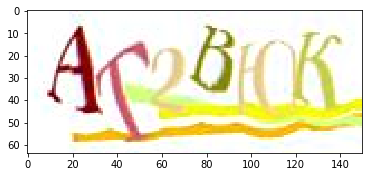

In [184]:
data_test.shape

(4357, 2)

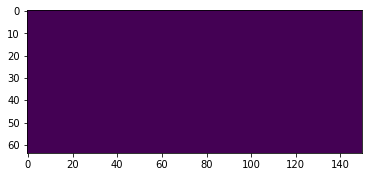

In [199]:
plt.imshow(X_r_test[11].reshape(64, 150))

In [195]:
print(my_model.predict(cut_into_six(X_r_test[11])).argmax(axis=1))

[32 32 32 32 32 32]


In [228]:
captcha_metrics = 0
for i in tqdm(range(len(X_r_test))):
    result = my_model.predict(cut_into_six(X_r_test[i]))
    y_predict = result.argmax(axis=1)
    y_pred_label = [classes_names[x] for x in y_predict]
    y_pred_label= "".join(y_pred_label)
    captcha_metrics += y_pred_label == y_r_test[i]
captcha_metrics /= len(X_r_test)
print(captcha_metrics)

0.6743171907275648


In [171]:
data_test.head()

FileName   Value
6925   c2874425-2e11-4586-a31e-affce48572dc.jpg  Б27РЕЦ
21607  b0804431-d55e-4683-99f3-2f79e7aac527.jpg  эсэ5чг
4946   6c0e12a9-b808-472c-a27e-a9fe1689d853.jpg  8ж2гаю
3401   9fa85b5c-380b-42fe-bc81-a5971bc6c0e9.jpg  Р5ДБС7
18573  ea43dec0-6e18-4acf-a99a-e7747fd063de.jpg  уюегюк

ValueError: cannot reshape array of size 4357 into shape (21783,)

In [81]:
def calculate_captcha_metrics(y_test, y_pred):
    print(len(y_pred))
    y_pred = np.argmax(y_pred, axis = 1).reshape(-1, 6)
    y_test = (np.argmax(y_test, axis=1)).reshape(-1, 6)
    
    print(y_pred)
calculate_captcha_metrics(Y_test, y_test_pred)

21783


ValueError: cannot reshape array of size 21783 into shape (6)

In [33]:
score = my_model.evaluate(X_test, Y_test, verbose=0)
score

[0.26893520518703035, 0.036876515]

In [32]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 60, 146, 32)       832       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 30, 73, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 26, 69, 56)        44856     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 13, 34, 56)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 9, 30, 64)         89664     
_________________________________________________________________
dropout_49 (Dropout)         (None, 9, 30, 64)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 17280)           

In [ ]:
print(f"результат обучения на чб {score}")

['Ж', 'Г', '7', 'Э', 'Ч', '7']


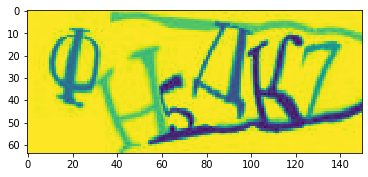

In [34]:
i = 8
try_0 = my_model.predict(X_test[i].reshape(1, 64, 150, 1)).reshape(-1, 35).argmax(axis=1)
print([classes_names[x] for x in try_0])
plt.imshow(X_test[i].reshape(64, 150))

In [175]:
test_res = my_model.predict(X_train)
test_res = test_res.reshape(X_train.shape[0], 6, 35)
test_res = test_res.argmax(axis=2)

In [165]:
test_res

array([[25, 17, 23, 11, 21,  6],
       [ 4, 25, 19,  4, 24, 32],
       [34, 33,  6, 30,  4, 24],
       ...,
       [ 8, 33,  9, 19,  6, 25],
       [ 5, 26, 20,  5,  8, 24],
       [27, 16,  3, 20,  4, 12]], dtype=int64)

In [168]:
Y_test =Y_test.reshape(4357, 6, 35)
Y_test = Y_test.argmax(axis=2)

In [176]:
Y_train = Y_train.reshape(Y_train.shape[0], 6, 35)
Y_train = Y_train.argmax(axis=2)